# GRPM Data Analyzer Module

This notebook is designed for statistical analysis. It assigns each gene a relative measure of interest based on the number and proportion of associated findings gathered in the GRPM dataset. This calculation enables the prioritization of genes related to a chosen topic, which can aid further investigations.

In [ ]:
#Only for Google Colab
import os
import sys
import subprocess

# @markdown Run in Colab virtual machine by default

# @markdown to run in google drive set:
import_mydrive = False #@param {type:"boolean"}


if 'google.colab' in sys.modules:
    subprocess.run(["pip", "install", "nbib"])
    subprocess.run(["pip", "install", "biopython"])

    if import_mydrive:
        from google.colab import drive
        drive.mount('/content/drive')

        if not os.path.exists('/content/drive/MyDrive/grpm_system/'):
            subprocess.run(['mkdir', '/content/drive/MyDrive/grpm_system/'])
        subprocess.run(['cd', '/content/drive/MyDrive/grpm_system/'])
    else:
        if not os.path.exists('/content/grpm_system/'):
            subprocess.run(['mkdir', '/content/grpm_system/'])
        subprocess.run(['cd', '/content/grpm_system/'])

current_directory = os.getcwd()
print("Current working directory:", current_directory)

# Import Packages

In [1]:
import os
import io
import sys
import glob
import zipfile
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
if not 'google.colab' in sys.modules:
    import pyperclip

def simple_bool(message):
    choose = input(message+" (y/n): ").lower()
    your_bool = choose in ["y", "yes","yea","sure"]
    return your_bool
      
def get_gitfile(url, flag='', dir = os.getcwd()):
    url = url.replace('blob','raw')
    response = requests.get(url)
    file_name = flag + url.rsplit('/',1)[1]
    file_path = os.path.join(dir, file_name)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully. Saved as {file_name}")
    else:
        print("Unable to download the file.")          

def get_and_extract(file, dir = os.getcwd(), ext = '.zip'):
    url='https://zenodo.org/record/8205724/files/'+file+'.zip?download=1'
    zip_file_name = file+ext
    extracted_folder_name = dir
    # Download the ZIP file
    response = requests.get(url)
    if response.status_code == 200:
        # Extract the ZIP contents
        with io.BytesIO(response.content) as zip_buffer:
            with zipfile.ZipFile(zip_buffer, 'r') as zip_ref:
                zip_ref.extractall(extracted_folder_name)
        print(f"ZIP file '{zip_file_name}' extracted to '{extracted_folder_name}' successfully.")
    else:
        print("Failed to download the ZIP file.")

# Get requirements

## Get GRPM Dataset from Zenodo

In [ ]:
# Get GRPM Dataset from Zenodo Repository
#https://zenodo.org/record/8205724  DOI: 10.5281/zenodo.8205724

if simple_bool('Download pre-made GRPM-Dataset from Zenodo?'):
    timea = datetime.now()
    get_and_extract('grpm_dataset')
    print('Download and extraction time ',datetime.now()-timea)

## Get pre-made survey datasets from Zenodo

In [2]:
%%time
if simple_bool('Download pre-made nutrigenetic-surveys from Zenodo?'):
    timea = datetime.now()
    get_and_extract('grpm_surveys')
    print('Download and extraction time ',datetime.now()-timea)

ZIP file 'grpm_surveys.zip' extracted to 'G:\Altri computer\Horizon\horizon_workspace\projects\semantics\GRPM\GRPM_github' successfully.
Download and extraction time  0:00:55.575851


## Import Ensembl Gene dataset

In [5]:
if not os.path.exists('human_genes_repo'):
    get_and_extract('human_genes_repo')

# Load Human Gene list (if needed)
protein_coding_genes = pd.read_csv('human_genes_repo/H_GENES_proteincoding_genes.csv')
IG_TR_genes          = pd.read_csv('human_genes_repo/H_GENES_IGTR_genes.csv')
RNA_genes            = pd.read_csv('human_genes_repo/H_GENES_RNA_genes.csv')
pseudo_genes         = pd.read_csv('human_genes_repo/H_GENES_pseudo_genes.csv')
misc_genes           = pd.read_csv('human_genes_repo/H_GENES_misc_genes.csv')

#First: protein coding genes:
protein_coding_genes_list = protein_coding_genes['Gene name'].dropna().tolist()
RNA_genes_list            = RNA_genes['Gene name'].dropna().tolist()
pseudo_genes_list         = pseudo_genes['Gene name'].dropna().tolist()

print('Ensembl genes:')
print('protein_coding_genes_list =',len(protein_coding_genes_list))
print('RNA_genes_list            =',len(RNA_genes_list))
print('pseudo_genes_list         =',len(pseudo_genes_list))

Ensembl genes:
protein_coding_genes_list = 19318
RNA_genes_list            = 11452
pseudo_genes_list         = 9866


# [Section 1]

# Import GRPM-dataset Report

In [6]:
#set source dataset:-----------------------

# pcg    = protein coding genes = grpm_db
# rna    = rna genes            = grpm_db_rna
# pseudo = pseudogenes          = grpm_db_pseudo
#------------------------------------------

def read_grpm_report(db_tag):
    db_name = 'grpm_db_' + db_tag
    db_path = 'grpm_dataset/' + db_name
    
    GRPM_report = pd.read_csv(db_path + '/GRPM_report.csv', index_col=0).transpose().reset_index().rename(columns={'index':'gene'})
    return GRPM_report

# Read GRPM_report for pcg
GRPM_report = read_grpm_report('pcg')

# Read GRPM_report for rna
GRPM_report_rna = read_grpm_report('rna')

# Read GRPM_report for pseudo
GRPM_report_pseudo = read_grpm_report('pseudo')


data_types = {
    'gene': str,
    'ncbi_dbsnp': int,
    'lit2_variant': int,
    'lit2_variant_norsid': int,
    'lit2_rsid': int,
    'lit2_rsid_plus1': int,
    'lit1_rsid': int,
    'lit1_rsid_pmid_plus1': int,
    'lit1_pmid': int,
    'lit1_pmid_pmid_plus1': int,
    'pubmed_pmid_query': int,
    'nbib_objects': int,
    'nbib_objects_withdescriptors': int,
    'pubmed_pmid': int,
    'pubmed_pmid_withmesh': int,
    'pubmed_pmidmesh': int,
    'pubmed_mesh_qualifier_major': int,
    'pubmed_mesh': int,
    'rsid_pmid10': int,
    'rsid_pmid50': int,
    'rsid_pmid100': str,
    'top10mesh_all': str,
    'top10rsid_all': str,
    'pubmed_runtime': str,
    'total_runtime': str,
    'time_stamp': str
    }
GRPM_report = GRPM_report.astype(data_types)
GRPM_report_rna = GRPM_report_rna.astype(data_types)
GRPM_report_pseudo = GRPM_report_pseudo.astype(data_types)

# Sort Values
sort_by_list = ['lit2_variant','lit1_pmid']
sort_by = sort_by_list[1]
GRPM_report_sort = GRPM_report.sort_values(by= sort_by,ascending = False).reset_index(drop=True)
GRPM_report_s_lit1pmid= GRPM_report.sort_values(by= 'lit1_pmid',ascending = False).reset_index(drop=True)
print('The GRPM Report harvest the numerical data through the data-mining process')
print('Report sorted by', sort_by)
GRPM_report_s_lit1pmid.head(100)

The GRPM Report harvest the numerical data through the data-mining process
Report sorted by lit1_pmid


,gene,ncbi_dbsnp,lit2_variant,lit2_variant_norsid,lit2_rsid,lit2_rsid_plus1,lit1_rsid,lit1_rsid_pmid_plus1,lit1_pmid,lit1_pmid_pmid_plus1,...,pubmed_mesh_qualifier_major,pubmed_mesh,rsid_pmid10,rsid_pmid50,rsid_pmid100,top10mesh_all,top10rsid_all,pubmed_runtime,total_runtime,time_stamp
0,TP53,10885,5858,3585,1587,1075,880,637,9002,8936,...,17274,5316,186,35,15,"['Humans', 'Female', 'Tumor Suppressor Protein...","['rs1042522', 'rs28934576', 'rs28934578', 'rs1...",0:06:22,0:07:45,2023-03-21 18:49:16.897957
1,MTHFR,9817,1040,200,675,362,263,132,8315,8303,...,15266,4762,13,3,3,"['Humans', 'Female', 'Male', 'Methylenetetrahy...","['rs1801133', 'rs1801131', 'rs2274976', 'rs173...",0:05:23,0:06:19,2023-03-22 10:31:03.464765
2,SNCA,42272,1322,796,498,275,203,87,4724,4715,...,9356,3247,12,5,5,"['Humans', 'Animals', 'alpha-Synuclein', 'Park...","['rs104893877', 'rs104893878', 'rs104893875', ...",0:03:14,0:03:40,2023-03-20 13:24:35.290344
3,TNF,1840,1842,1543,237,119,122,65,4287,4260,...,11485,3991,17,7,5,"['Humans', 'Female', 'Male', 'Tumor Necrosis F...","['rs1800629', 'rs361525', 'rs1799964', 'rs1799...",0:01:51,0:02:15,2023-03-14 11:33:43.998754
4,BDNF,25241,582,178,353,193,153,85,3956,3934,...,8647,3208,27,4,2,"['Humans', 'Male', 'Female', 'Brain-Derived Ne...","['rs6265', 'rs2030324', 'rs11030104', 'rs10767...",0:02:00,0:02:25,2023-03-14 12:54:46.408228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,MMP9,4431,596,206,337,155,99,46,934,913,...,3699,1661,14,4,2,"['Humans', 'Female', 'Male', 'Matrix Metallopr...","['rs3918242', 'rs17576', 'rs17577', 'rs2250889...",0:00:26,0:00:35,2023-03-15 15:18:23.684231
96,JAK2,67103,2070,426,1514,559,249,121,926,879,...,3551,1537,12,2,1,"['Humans', 'Janus Kinase 2', 'Female', 'Mutati...","['rs77375493', 'rs1057519721', 'rs121912473', ...",0:00:28,0:00:38,2023-03-17 12:56:17.974286
97,INSL6,89607,1147,5,1142,625,240,117,910,867,...,3168,1390,9,1,1,"['Humans', 'Janus Kinase 2', 'Female', 'Mutati...","['rs77375493', 'rs1057519721', 'rs121912473', ...",0:00:25,0:00:37,2023-03-20 21:18:51.251322
98,CDKN2A,13355,1636,833,601,382,278,172,907,865,...,3578,1603,21,4,0,"['Humans', 'Female', 'Male', 'Middle Aged', 'A...","['rs3731249', 'rs3088440', 'rs104894094', 'rs1...",0:00:27,0:00:40,2023-03-20 17:30:12.950705


In [10]:
# Function to print gene information
def print_gene_info(title, gene_type, gene_list):
    print(f'{title} = {len(gene_list)}')

# Ensembl genes
print('Ensembl genes:')
print_gene_info('protein_coding_genes_list', 'pc', protein_coding_genes_list)
print_gene_info('RNA_genes_list', 'rna', RNA_genes_list)
print_gene_info('pseudo_genes_list', 'ps', pseudo_genes_list)

# Genes in GRPM dataset % over total
print('\nGenes in GRPM dataset % over total:')
print('pc:', GRPM_report.gene.nunique() / len(protein_coding_genes_list))
print('rna:', GRPM_report_rna.gene.nunique() / len(RNA_genes_list))
print('ps:', GRPM_report_pseudo.gene.nunique() / len(pseudo_genes_list))

Ensembl genes:
protein_coding_genes_list = 19318
RNA_genes_list = 11452
pseudo_genes_list = 9866

Genes in GRPM dataset % over total:
pc: 0.8033440314732374
rna: 0.22135871463499826
ps: 0.021285221974457733


## Data visualization

### 1. pie graphs-treemaps

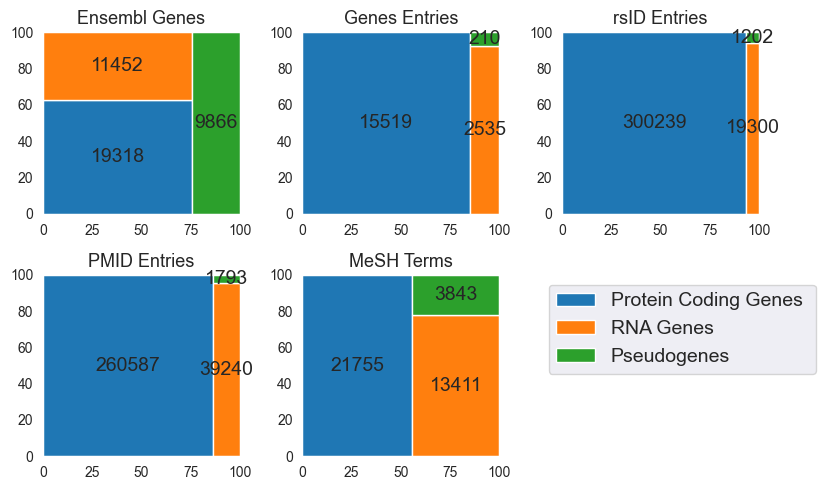

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import squarify

# Check if the dataset exists, if not, download it
if not os.path.exists('misc_data/db_stats.csv'):
    os.mkdir('misc_data')
    get_gitfile(url="https://raw.githubusercontent.com/johndef64/GRPM_system/main/misc_data/db_stats.csv", dir='misc_data')

# Read the dataset into a pandas DataFrame
if os.path.exists('misc_data/db_stats.csv'):
    df = pd.read_csv('misc_data/db_stats.csv', sep=',')

    # Extract the required columns
    ensembl_genes = df["Ensembl Genes"]
    genes_entries = df["Genes Entries"]
    rsid_entries = df["rsID Entries"]
    pmid_entries = df["PMID Entries"]
    mesh_terms = df["MeSH Terms"]

    # Set random colors for the treemaps
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

    # Create a figure and axes for the treemaps
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))

    # Create treemaps for each category
    squarify.plot(sizes=ensembl_genes, label=df["Ensembl Genes"], color=colors, ax=axes[0, 0], text_kwargs={'fontsize': 14}),
    squarify.plot(sizes=genes_entries, label=df["Genes Entries"], color=colors, ax=axes[0, 1], text_kwargs={'fontsize': 14}),
    squarify.plot(sizes=rsid_entries, label=df["rsID Entries"], color=colors, ax=axes[0, 2], text_kwargs={'fontsize': 14}),
    squarify.plot(sizes=pmid_entries, label=df["PMID Entries"], color=colors, ax=axes[1, 0], text_kwargs={'fontsize': 14}),
    squarify.plot(sizes=mesh_terms, label=df["MeSH Terms"], color=colors, ax=axes[1, 1], text_kwargs={'fontsize': 14}),

    # Set titles for each treemap
    axes[0, 0].set_title("Ensembl Genes",fontsize=13)
    axes[0, 1].set_title("Genes Entries",fontsize=13)
    axes[0, 2].set_title("rsID Entries", fontsize=13)
    axes[1, 0].set_title("PMID Entries", fontsize=13)
    axes[1, 1].set_title("MeSH Terms",   fontsize=13)

    # Remove unused plot axes
    axes[1, 2].remove()

    # Set the layout and display the graphs
    plt.tight_layout()
    plt.legend(df["Database Partition"],prop={'size': 14}, bbox_to_anchor=(1.2, 1))

    plt.savefig('misc_data/treemaps.png', dpi=300)
    plt.show()

### 2. bars graphs

In [ ]:
#stats
GRPM_report_s_lit1pmid.columns
GRPM_report_s_lit1pmid.T

In [ ]:
# stats
percentage = (GRPM_report.pubmed_pmid_withmesh.mean() / GRPM_report.lit1_pmid.mean()) * 100

def generate_bars(data= GRPM_report,
                  gene_f=0,
                  gene_l=50,
                  sort_by='lit1_pmid',
                  value1 = 'lit1_pmid',
                  value2 = 'pubmed_pmid_withmesh'):
    GRPM_report_s  = data.sort_values(by=sort_by, ascending=False).reset_index(drop=True)
    genes          = GRPM_report_s[gene_f:gene_l]['gene']
    grpm_data      = {
        'LitVar1 PMIDs': GRPM_report_s[gene_f:gene_l][value1],
        'PubMed PMIDs with MeSH': GRPM_report_s[gene_f:gene_l][value2],
    }

    x = np.arange(len(genes))  # the label locations
    width = 0.35  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=((gene_l-gene_f) * 0.2, (gene_l-gene_f) * 0.1))


    for attribute, measurement in grpm_data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        #ax.bar_label(rects, padding=3)
        multiplier += 1

    #plt.title('Top ' + str(gene_f) + ':' + str(gene_l) + ' genes in db: ' + value1 + ', ' + value2)
    plt.ylabel('PMID count')
    plt.xticks(rotation=90)
    ax.set_xticks(x + width, genes)
    ax.legend(loc='upper right', ncols=3)
    print('Top',gene_f,':',gene_l,'studied genes in the GRPM database')
    print('     in evidence: data loss during the db building process, the majority of LitVar PMIDs has MeSH terms related in PubMed','('+str(round(percentage,1))+'%)')

generate_bars()
plt.savefig('misc_data/figbar_11.png', dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def generate_nested(data, gene_f, gene_l, sort_by, value1, value2, label1, label2):
    GRPM_report_s = data.sort_values(by=sort_by, ascending=False).reset_index(drop=True)

    x  = GRPM_report_s[gene_f:gene_l]['gene']
    y1 = GRPM_report_s[gene_f:gene_l][value1]
    y2 = GRPM_report_s[gene_f:gene_l][value2]

    plt.figure(figsize=((gene_l-gene_f) * 0.2, (gene_l-gene_f) * 0.1))
    plt.bar(x, y1, width=1, label=label1, color='blue', alpha=0.7, edgecolor='black', linewidth=1)
    plt.bar(x, y2, width=0.5, label=label2, color='orange', edgecolor='black', linewidth=1)
    plt.xlabel('Gene')
    plt.ylabel(value1 + '\n' + value2)
    plt.title('Top ' + str(gene_f) + ':' + str(gene_l) + ' genes in db: ' + value1 + ', ' + value2)
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()  # Ensures all labels and ticks are visible
    print('Top',gene_f,':',gene_l,'studied genes in the GRPM database')
    print('     in evidence: data loss during the db building process, the majority of LitVar PMIDs has MeSH terms related in PubMed','('+str(round(percentage,1))+'%)')
    plt.show()

parameters =     {
        'sort_by': 'lit1_pmid',
        'value1': 'lit1_pmid',
        'value2': 'pubmed_pmid_withmesh',#'pubmed_pmid',
        'label1': 'LitVar1 PMIDs',
        'label2': 'PubMed PMIDs with MeSH'
}

# Call the function with your data and parameters
generate_nested(GRPM_report, 
                gene_f =0, 
                gene_l =50, 
                **parameters)

In [ ]:
pd.DataFrame(GRPM_report.columns)

In [ ]:
gene_f = 50
sort_by = 'lit1_pmid'
value1  = 'lit1_pmid'
value2  = 'pubmed_mesh'
#-----------------------------

GRPM_report_s = GRPM_report.sort_values(by= sort_by,ascending = False).reset_index(drop=True)
x =  GRPM_report_s[:gene_f]['gene']
y1 = GRPM_report_s[:gene_f][value1]/GRPM_report_s[:gene_f][value1].max()
y2 = GRPM_report_s[:gene_f][value2]/GRPM_report_s[:gene_f][value2].max()

plt.figure(figsize=( gene_f*0.2, gene_f*0.1))
plt.bar(x, y1, width=1, label=value1, color='blue', alpha=0.7, edgecolor='black', linewidth=1)
plt.bar(x, y2, width=0.5, label=value2, color='yellow', edgecolor='black', linewidth=1)
plt.xlabel('Gene')
plt.ylabel(value1+'\n'+value2)
plt.title('Top '+str(gene_f)+' genes in db: '+value1+' , '+value2)
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()  # Ensures all labels and ticks are visible

print(r'Show gene relative enrichment for "'+value1+'" and "'+value2+'" for ',gene_f,' genes in db.')
plt.show()

# Import GRPM-survey Reports

## check available surveys

In [13]:
# choose db
db_tag = 'pcg'
    # pcg    = protein coding genes = grpm_db_pcg
    # rna    = rna genes            = grpm_db_rna
    # pseudo = pseudogenes          = grpm_db_pseudo
#-------------------------------------------------

# Create an empty list to store folder names
folder_names = []
current_dir = os.getcwd()+'/grpm_surveys'
# Iterate over the directories in the workspace
for root, dirs, files in os.walk(current_dir):
    for dir_name in dirs:
        # Check if the folder name contains the string 'survey'
        if 'survey' in dir_name:
            folder_names.append(dir_name)

# Create a pandas Series from the list of folder names
folder_series = pd.Series(folder_names).sort_values(ascending=True).reset_index(drop=True)
print('Available survey repositories:\n')
folder_series = folder_series.str.replace('grpm_survey_'+db_tag+'_','')
# Print the resulting Series
print(folder_series)

Available survey repositories:

0             aller
1               cvd
2           dmt2_ms
3         eat_taste
4     heart_failure
5             intol
6          ng_intol
7         ng_ob_bmi
8             nutri
9            ob_bmi
10       oxi_stress
11            vitam
12             xeno
dtype: object


## import surveys

In [14]:
# Select surveys directories from Available survey repositories:

# 1. select manually to get a specific order
nutri_g_surveys = ['nutri',
                   'ob_bmi',
                   'dmt2_ms',
                   'cvd',
                   'vitam',
                   'eat_taste',
                   'intol',
                   'aller',
                   'oxi_stress',
                   'xeno']
selected_surveys = pd.Series(nutri_g_surveys) 

# 2. select by indexes
if simple_bool('select by index?'):
    selected_surveys = folder_series.iloc[[int(x) for x in input('select index list (0,1,2 etc):\n'+str(folder_series)).split(',')]]

# do you want to import randoms?
import_random = simple_bool('Import random surveys?')
# select your randoms from 'grpm_random/' folder
random_num = ['01','02','03','04','05','06','07','08','09','00','norep1','norep2','norep3','norep4','norep5','norep6','norep7','norep8','norep9','norep10','norep11']

#-------------------------------------------
# Batch directories importer:
timea = datetime.now()
survey_path = 'grpm_surveys/'

first, last = 0, len(selected_surveys)
directories = []
dir_names = ['directory_'] * last
dir_names = [string + str(i+1) for i, string in enumerate(dir_names)]
for folder, name in zip(selected_surveys,
                        dir_names):#[:len(selected_surveys)]):
    director =  survey_path+'grpm_survey_'+ db_tag + '_'+ folder
    globals()[name] = director
    directories.append(globals()[name])

#define random directories
if import_random == True:
    dir_names = ['directory_'] * len(random_num)
    dir_names = [string + str(i+len(selected_surveys)) for i, string in enumerate(dir_names)]
    for folder, name in zip(random_num,
                            dir_names):
        director =  survey_path+'grpm_random/grpm_random_'+ db_tag + '_'+ folder
        globals()[name] = director
        directories.append(globals()[name])

    last = len(directories)

# key parameters
survey_ser = pd.Series(directories)[pd.Series(directories).str.contains('survey')]
survey_l = len(survey_ser)
random_l = len(directories) - survey_l

#----------------------------------
# import GRPMX reports
repo_list_names = ['GRPMX_report_'] * last
repo_list_names = [string + str(i+1) for i, string in enumerate(repo_list_names)]
repo_list_names = repo_list_names[first:last]

repo_list = []
for directory, name in zip(directories, repo_list_names):
    dataframe = pd.read_csv(directory +'/GRPMX_report.csv', index_col=0).transpose().reset_index().rename(columns={'index':'gene'})
    globals()[name] = dataframe
    repo_list.append(dataframe)

    print(name,'df loaded')

# set datatype:
for i, repo in enumerate(repo_list):
  data_types = {
      'gene': str,
      'reference_mesh': int,
      'starting_pmidmesh': int,
      'starting_pmid': int,
      'starting_mesh': int,
      'starting_rsid': int,
      'matching_pmidmesh': int,
      'matching_pmids': int,
      'matching_mesh': int,
      'matching_rsid': int,
      'dropped_rsid': int,
      'matching_mesh_ratio': float,
      'matching_pmids_ratio': float,
      'matching_pmidmesh_ratio': float,
      'matching_rsid_ratio': float,
      'matching_rsid_pmid10': str,
      'matching_rsid_pmid100': str,
      'matching_top10mesh': str,
      'matching_top10rsid': str
  }
  repo_list[i] = repo.astype(data_types)

print('import time:',datetime.now()-timea)

GRPMX_report_1 df loaded
GRPMX_report_2 df loaded
GRPMX_report_3 df loaded
GRPMX_report_4 df loaded
GRPMX_report_5 df loaded
GRPMX_report_6 df loaded
GRPMX_report_7 df loaded
GRPMX_report_8 df loaded
GRPMX_report_9 df loaded
GRPMX_report_10 df loaded
GRPMX_report_11 df loaded
GRPMX_report_12 df loaded
GRPMX_report_13 df loaded
GRPMX_report_14 df loaded
GRPMX_report_15 df loaded
GRPMX_report_16 df loaded
GRPMX_report_17 df loaded
GRPMX_report_18 df loaded
GRPMX_report_19 df loaded
GRPMX_report_20 df loaded
GRPMX_report_21 df loaded
GRPMX_report_22 df loaded
GRPMX_report_23 df loaded
GRPMX_report_24 df loaded
GRPMX_report_25 df loaded
GRPMX_report_26 df loaded
GRPMX_report_27 df loaded
GRPMX_report_28 df loaded
GRPMX_report_29 df loaded
GRPMX_report_30 df loaded
GRPMX_report_31 df loaded
import time: 0:00:39.536029


In [ ]:
repo_list[0].head()

## generate master_df

In [15]:
#creare master_df:
master_df = pd.DataFrame({'directories': directories, 'repo_list': repo_list_names})
custom_labels = True

# add tags to master df:
if import_random:
    tags = master_df.directories.str.replace(survey_path+'grpm_survey_pcg_','').str.replace(survey_path+'grpm_random/grpm_random_pcg_','').to_list()
else:
    tags = master_df.directories.str.replace(survey_path+'grpm_survey_pcg_','').to_list()
master_df['tag'] = tags

# add labels to master df:

# define custom labels
titles = [
    "General Nutrition",
    "Obesity, Weight Control and Compulsive Eating",
    "Diabetes Mellitus Type II and Metabolic Syndrome",
    "Cardiovascular Health and Lipid Metabolism",
    "Vitamin and Micronutrients Metabolism and Deficiency-Related Diseases",
    "Eating Behavior and Taste Sensation",
    "Food Intolerances",
    "Food Allergies",
    "Diet-induced Oxidative Stress",
    "Xenobiotics Metabolism" #or  bioactive compounds metabolism
]

short_labels = ['Gen Nutrition',
                'Obesity & Weight',
                'Diabetes Type II',
                'Cardiovascular Hlth',
                'Vitamins & Minerals',
                'Eating Behavior',
                'Food Intolerances',
                'Food Allergies',
                'Oxidative Stress',
                'Xenobiotics Metab']

add_rand = ['random'] * (len(master_df)- len(titles))
titles.extend(add_rand)
short_labels.extend(add_rand)

# add labels:
if custom_labels and len(master_df)>=10:
    master_df['label'] = titles
    master_df['short_labels'] = short_labels
    for i in [0,1,2]:
        last_column = master_df.columns[-1]
        last_column_data = master_df.pop(last_column)
        master_df.insert(0, last_column, last_column_data)
else:
    last_column = master_df.columns[-1]
    last_column_data = master_df.pop(last_column)
    master_df['label'] = tags
    master_df['short_labels'] = tags
    master_df.insert(0, last_column, last_column_data)

taglabel = 'short_labels' if custom_labels else 'tag'
master_df

,tag,label,short_labels,directories,repo_list
0,nutri,General Nutrition,Gen Nutrition,grpm_surveys/grpm_survey_pcg_nutri,GRPMX_report_1
1,ob_bmi,"Obesity, Weight Control and Compulsive Eating",Obesity & Weight,grpm_surveys/grpm_survey_pcg_ob_bmi,GRPMX_report_2
2,dmt2_ms,Diabetes Mellitus Type II and Metabolic Syndrome,Diabetes Type II,grpm_surveys/grpm_survey_pcg_dmt2_ms,GRPMX_report_3
3,cvd,Cardiovascular Health and Lipid Metabolism,Cardiovascular Hlth,grpm_surveys/grpm_survey_pcg_cvd,GRPMX_report_4
4,vitam,Vitamin and Micronutrients Metabolism and Defi...,Vitamins & Minerals,grpm_surveys/grpm_survey_pcg_vitam,GRPMX_report_5
5,eat_taste,Eating Behavior and Taste Sensation,Eating Behavior,grpm_surveys/grpm_survey_pcg_eat_taste,GRPMX_report_6
6,intol,Food Intolerances,Food Intolerances,grpm_surveys/grpm_survey_pcg_intol,GRPMX_report_7
7,aller,Food Allergies,Food Allergies,grpm_surveys/grpm_survey_pcg_aller,GRPMX_report_8
8,oxi_stress,Diet-induced Oxidative Stress,Oxidative Stress,grpm_surveys/grpm_survey_pcg_oxi_stress,GRPMX_report_9
9,xeno,Xenobiotics Metabolism,Xenobiotics Metab,grpm_surveys/grpm_survey_pcg_xeno,GRPMX_report_10


In [ ]:
#check
n = 0
if simple_bool('check?'):
    print('check import process:')
    print(repo_list[n].iloc[:,[1,7,8]].head())
    GRPMX_check = pd.read_csv(directories[n]+'/GRPMX_report.csv', index_col=0).transpose().reset_index().rename(columns={'index':'gene'})
    print('\n',GRPMX_check.iloc[:, [1,7,8]].head())

# [Section 2]

# Import GRPM-survey Datasets

In [16]:
# import GRPMX data
grpm_out_names = ['GRPMX_'] * last
grpm_out_names = [string + str(i+1) for i, string in enumerate(grpm_out_names)]
grpm_out_names = grpm_out_names[first:last]

grpm_out_list = []
print('Importing GRPMX csv, please wait...')
for directory, name in zip(directories, grpm_out_names):
    dataframe = pd.read_csv(directory + '/grpmx_filtered_output.csv', index_col=0, dtype={'pmids': str})
    globals()[name] = dataframe
    grpm_out_list.append(dataframe)
    #print(name,'df loaded')
print('all GRPMX csv loaded')

master_df['grpm_out_list'] = grpm_out_names

for i in range(len(directories)):
    master_df.at[i,'grpm_genes'] = grpm_out_list[i].gene.nunique()
    master_df.at[i,'grpm_rsids'] = grpm_out_list[i].rsid.nunique()
    master_df.at[i,'grpm_pmids'] = grpm_out_list[i].pmids.nunique()
    master_df.at[i,'grpm_meshs'] = grpm_out_list[i].mesh.nunique()

columns_to_convert = ['grpm_genes','grpm_rsids', 'grpm_pmids', 'grpm_meshs']
master_df[columns_to_convert] = master_df[columns_to_convert].astype(int)

print('\ngrpm_out list len:',len(grpm_out_list))

common_cols = ['tag', 'grpm_genes', 'grpm_rsids', 'grpm_pmids', 'grpm_meshs']
master_cols = common_cols if not custom_labels else common_cols[:1] + ['short_labels'] + common_cols[1:]
master_df_ref = master_df.loc[:,master_cols]

master_df[master_df.directories.str.contains('survey')]

Importing GRPMX csv, please wait...
all GRPMX csv loaded

grpm_out list len: 31


,tag,label,short_labels,directories,repo_list,grpm_out_list,grpm_genes,grpm_rsids,grpm_pmids,grpm_meshs
0,nutri,General Nutrition,Gen Nutrition,grpm_surveys/grpm_survey_pcg_nutri,GRPMX_report_1,GRPMX_1,11560,83288,62473,413
1,ob_bmi,"Obesity, Weight Control and Compulsive Eating",Obesity & Weight,grpm_surveys/grpm_survey_pcg_ob_bmi,GRPMX_report_2,GRPMX_2,9713,53879,35563,243
2,dmt2_ms,Diabetes Mellitus Type II and Metabolic Syndrome,Diabetes Type II,grpm_surveys/grpm_survey_pcg_dmt2_ms,GRPMX_report_3,GRPMX_3,10717,68844,49896,319
3,cvd,Cardiovascular Health and Lipid Metabolism,Cardiovascular Hlth,grpm_surveys/grpm_survey_pcg_cvd,GRPMX_report_4,GRPMX_4,12368,105598,85065,528
4,vitam,Vitamin and Micronutrients Metabolism and Defi...,Vitamins & Minerals,grpm_surveys/grpm_survey_pcg_vitam,GRPMX_report_5,GRPMX_5,4045,16857,11941,175
5,eat_taste,Eating Behavior and Taste Sensation,Eating Behavior,grpm_surveys/grpm_survey_pcg_eat_taste,GRPMX_report_6,GRPMX_6,5525,20607,13734,292
6,intol,Food Intolerances,Food Intolerances,grpm_surveys/grpm_survey_pcg_intol,GRPMX_report_7,GRPMX_7,4040,14117,7416,145
7,aller,Food Allergies,Food Allergies,grpm_surveys/grpm_survey_pcg_aller,GRPMX_report_8,GRPMX_8,4681,16777,11032,65
8,oxi_stress,Diet-induced Oxidative Stress,Oxidative Stress,grpm_surveys/grpm_survey_pcg_oxi_stress,GRPMX_report_9,GRPMX_9,5156,20919,19295,77
9,xeno,Xenobiotics Metabolism,Xenobiotics Metab,grpm_surveys/grpm_survey_pcg_xeno,GRPMX_report_10,GRPMX_10,7115,35686,27237,170


In [ ]:
#check import process
i = 0
if simple_bool('check?'):
    print(pd.read_csv(directories[i] +'/grpmx_filtered_output.csv',index_col=0).head())
    print(grpm_out_list[i].head())

# Add "gene interest index" to report

In [17]:
## Add "interest index" to report:

# set True if generating interest for the first time:
replace_all = False

#---------------------------------------
def add_interest_index(df):
    max_match_pmids = int(df['matching_pmids'].max())
    # duplicate df
    df_int = df#.copy()
    df_int['matching_pmids_index'] = round((df_int['matching_pmids'] / max_match_pmids), 5)
    df_int['interest_value'] = round(df_int['matching_pmids_index'] * df_int['matching_pmids_ratio'], 5)
    df_int['interest_index'] = round(df_int['interest_value']/df_int['interest_value'].max(), 5)
    df_int['matching_mesh_ref_ratio'] = round(df_int['matching_mesh'] / df_int['reference_mesh'], 5)
    new_col_order = ['gene', 'interest_value','interest_index', 'reference_mesh', 'starting_pmidmesh',
                     'starting_pmid', 'starting_mesh', 'starting_rsid',
                     'matching_pmids_index','matching_pmidmesh', 'matching_pmids',
                     'matching_mesh', 'matching_rsid',
                     'dropped_rsid', 'matching_mesh_ratio',
                     'matching_mesh_ref_ratio', 'matching_pmids_ratio',
                     'matching_pmidmesh_ratio', 'matching_rsid_ratio',
                     'matching_rsid_pmid10', 'matching_rsid_pmid100', 'matching_top10mesh',
                     'matching_top10rsid']
    df_int = df[new_col_order]
    return df_int
#---------------------------------------

##GRPMX_report_int
report_int_names = ['GRPMX_report_int_'] * last
report_int_names = [string + str(i) for i, string in enumerate(report_int_names)]
report_int_names = report_int_names[first:last]
master_df['repo_int_list'] = report_int_names

print('Adding/loading interest values...')
repo_int_list = []
for repo, name, directory in zip(repo_list, report_int_names, directories):
    if replace_all == True or os.path.exists(directory + '/GRPMX_report_int.csv') == False:
        dataframe = add_interest_index(repo)
        globals()[name] = dataframe
        dataframe.to_csv(directory+'/GRPMX_report_int.csv', index=0)
        repo_int_list.append(dataframe)
        #print(name,'df created')
    else:
        dataframe = pd.read_csv(directory + '/GRPMX_report_int.csv')
        data_types = {
            'gene': str,
            'reference_mesh': int,
            'starting_pmidmesh': int,
            'starting_pmid': int,
            'starting_mesh': int,
            'starting_rsid': int,
            'matching_pmidmesh': int,
            'matching_pmids': int,
            'matching_mesh': int,
            'matching_rsid': int,
            'dropped_rsid': int,
            'interest_value': float,
            'interest_index': float,
            'matching_mesh_ratio': float,
            'matching_mesh_ref_ratio': float,
            'matching_pmids_ratio': float,
            'matching_pmidmesh_ratio': float,
            'matching_rsid_ratio': float,
            'matching_pmids_index': float,
            'matching_rsid_pmid10' : str,
            'matching_rsid_pmid100': str,
            'matching_top10mesh': str,
            'matching_top10rsid': str
            }
        dataframe = dataframe.astype(data_types)
        globals()[name] = dataframe
        repo_int_list.append(dataframe)
        #print(name,'df loaded')

if replace_all:
    print('interest values added to all GRPM reports')
else:
    print('all stored GRPM report with interest values loaded')

if False:
    for repo in repo_int_list:
        repo.drop(['starting_pmidmesh', 'starting_pmid','starting_mesh', 'starting_rsid'],axis=1, inplace=True)

#-------------------------------
#Sort for interest index
print('\nSorting GRPMX reports by interest index...')

def sortby_int(df):
    df_int_sort = df.sort_values(by='interest_index',ascending=False).reset_index(drop=True)
    return df_int_sort

repo_int_sort_name = [term + '_sort' for term in report_int_names]
repo_int_sort_name = repo_int_sort_name[first:last]
master_df['repo_int_sort_list'] = repo_int_sort_name

repo_int_sort_list = []
for directory, name, repo in zip(directories, repo_int_sort_name, repo_int_list):
    dataframe = sortby_int(repo)
    globals()[name] = dataframe
    repo_int_sort_list.append(dataframe)
    #print(name,'df sorted')
    
print('all reports sorted by interest index')
print('\nAll reports:')
for i in range(len(directories[:survey_l])):
    name = master_df.tag.iloc[i]
    print(name.ljust(10), ' genes:', ('{:,.0f}'.format(grpm_out_list[i].gene.nunique())).ljust(10),'max int_value:', repo_int_sort_list[i].interest_value.max() )

master_df.T

Adding/loading interest values...
all stored GRPM report with interest values loaded

Sorting GRPMX reports by interest index...
all reports sorted by interest index

All reports:
nutri       genes: 11,560     max int_value: 0.48662
ob_bmi      genes: 9,713      max int_value: 0.77371
dmt2_ms     genes: 10,717     max int_value: 0.54997
cvd         genes: 12,368     max int_value: 0.4929
vitam       genes: 4,045      max int_value: 0.46384
eat_taste   genes: 5,525      max int_value: 0.36156
intol       genes: 4,040      max int_value: 0.21476
aller       genes: 4,681      max int_value: 0.18045
oxi_stress  genes: 5,156      max int_value: 0.591
xeno        genes: 7,115      max int_value: 0.868
01          genes: 12,972     max int_value: 0.72298
02          genes: 12,676     max int_value: 0.33519
03          genes: 11,182     max int_value: 0.661
04          genes: 14,128     max int_value: 0.65859
05          genes: 14,863     max int_value: 0.713
06          genes: 13,997     max 

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
tag,nutri,ob_bmi,dmt2_ms,cvd,vitam,eat_taste,intol,aller,oxi_stress,xeno,...,norep2,norep3,norep4,norep5,norep6,norep7,norep8,norep9,norep10,norep11
label,General Nutrition,"Obesity, Weight Control and Compulsive Eating",Diabetes Mellitus Type II and Metabolic Syndrome,Cardiovascular Health and Lipid Metabolism,Vitamin and Micronutrients Metabolism and Defi...,Eating Behavior and Taste Sensation,Food Intolerances,Food Allergies,Diet-induced Oxidative Stress,Xenobiotics Metabolism,...,random,random,random,random,random,random,random,random,random,random
short_labels,Gen Nutrition,Obesity & Weight,Diabetes Type II,Cardiovascular Hlth,Vitamins & Minerals,Eating Behavior,Food Intolerances,Food Allergies,Oxidative Stress,Xenobiotics Metab,...,random,random,random,random,random,random,random,random,random,random
directories,grpm_surveys/grpm_survey_pcg_nutri,grpm_surveys/grpm_survey_pcg_ob_bmi,grpm_surveys/grpm_survey_pcg_dmt2_ms,grpm_surveys/grpm_survey_pcg_cvd,grpm_surveys/grpm_survey_pcg_vitam,grpm_surveys/grpm_survey_pcg_eat_taste,grpm_surveys/grpm_survey_pcg_intol,grpm_surveys/grpm_survey_pcg_aller,grpm_surveys/grpm_survey_pcg_oxi_stress,grpm_surveys/grpm_survey_pcg_xeno,...,grpm_surveys/grpm_random/grpm_random_pcg_norep2,grpm_surveys/grpm_random/grpm_random_pcg_norep3,grpm_surveys/grpm_random/grpm_random_pcg_norep4,grpm_surveys/grpm_random/grpm_random_pcg_norep5,grpm_surveys/grpm_random/grpm_random_pcg_norep6,grpm_surveys/grpm_random/grpm_random_pcg_norep7,grpm_surveys/grpm_random/grpm_random_pcg_norep8,grpm_surveys/grpm_random/grpm_random_pcg_norep9,grpm_surveys/grpm_random/grpm_random_pcg_norep10,grpm_surveys/grpm_random/grpm_random_pcg_norep11
repo_list,GRPMX_report_1,GRPMX_report_2,GRPMX_report_3,GRPMX_report_4,GRPMX_report_5,GRPMX_report_6,GRPMX_report_7,GRPMX_report_8,GRPMX_report_9,GRPMX_report_10,...,GRPMX_report_22,GRPMX_report_23,GRPMX_report_24,GRPMX_report_25,GRPMX_report_26,GRPMX_report_27,GRPMX_report_28,GRPMX_report_29,GRPMX_report_30,GRPMX_report_31
grpm_out_list,GRPMX_1,GRPMX_2,GRPMX_3,GRPMX_4,GRPMX_5,GRPMX_6,GRPMX_7,GRPMX_8,GRPMX_9,GRPMX_10,...,GRPMX_22,GRPMX_23,GRPMX_24,GRPMX_25,GRPMX_26,GRPMX_27,GRPMX_28,GRPMX_29,GRPMX_30,GRPMX_31
grpm_genes,11560,9713,10717,12368,4045,5525,4040,4681,5156,7115,...,12479,12437,14266,12545,12886,12419,13166,10992,12812,12541
grpm_rsids,83288,53879,68844,105598,16857,20607,14117,16777,20919,35686,...,105409,114488,160638,110650,117067,115583,131242,73230,144411,108598
grpm_pmids,62473,35563,49896,85065,11941,13734,7416,11032,19295,27237,...,64209,62015,93838,69849,60307,69657,82505,44699,93451,94316
grpm_meshs,413,243,319,528,175,292,145,65,77,170,...,444,444,444,444,444,444,444,444,444,444


In [ ]:
n = 0
repo_int_sort_list[n].loc[:,['gene','interest_value']]

In [18]:
# Defining interest_index threshold:
int_val_threshold = 0.0055 # empirically defined

print('Equivalence table:\n interest index vs interest value threshold')
print('\nCorresponding interest index to int_value:')
print('\nint_value threshold =', int_val_threshold)
list_obj = []
for i, repo in enumerate(repo_int_sort_list) :
    if 'survey' in master_df.directories.iloc[i]:
        list_obj.append(repo[repo.interest_value>=int_val_threshold].interest_index.min())
        name = master_df.tag.iloc[i]
        print(name.ljust(10),' int index:', repo[repo.interest_value>=int_val_threshold].interest_index.min())
print('\nConverting threshold on Interest Index (mean) =', round(pd.Series(list_obj).mean(), 4))

#check repo
print(f'\nReport for {directories[0]}:')
repo_int_sort_list[0]

Equivalence table:
 interest index vs interest value threshold

Corresponding interest index to int_value:

int_value threshold = 0.0055
nutri       int index: 0.0113
ob_bmi      int index: 0.00711
dmt2_ms     int index: 0.01004
cvd         int index: 0.01116
vitam       int index: 0.01197
eat_taste   int index: 0.01521
intol       int index: 0.02561
aller       int index: 0.03053
oxi_stress  int index: 0.00939
xeno        int index: 0.00634
01          int index: 0.00761
02          int index: 0.01641
03          int index: 0.00832
04          int index: 0.00835
05          int index: 0.00771
06          int index: 0.01062
07          int index: 0.00558
08          int index: 0.01444
09          int index: 0.00942
00          int index: 0.01392
norep1      int index: 0.01046
norep2      int index: 0.00672
norep3      int index: 0.01703
norep4      int index: 0.01107
norep5      int index: 0.01375
norep6      int index: 0.01644
norep7      int index: 0.02169
norep8      int index: 0.01

,gene,interest_value,interest_index,reference_mesh,starting_pmidmesh,starting_pmid,starting_mesh,starting_rsid,matching_pmids_index,matching_pmidmesh,...,dropped_rsid,matching_mesh_ratio,matching_mesh_ref_ratio,matching_pmids_ratio,matching_pmidmesh_ratio,matching_rsid_ratio,matching_rsid_pmid10,matching_rsid_pmid100,matching_top10mesh,matching_top10rsid
0,FTO,0.48662,1.00000,603,22089,1508,2041,335,0.57588,3529,...,36,0.092,0.31012,0.845,0.160,0.893,30,4,"['Obesity', 'Body Mass Index', 'Diabetes Melli...","['rs9939609', 'rs8050136', 'rs1421085', 'rs155..."
1,MTHFR,0.41000,0.84255,603,76291,5406,4762,191,1.00000,4149,...,75,0.044,0.34494,0.410,0.054,0.607,6,2,"['Folic Acid', 'Dietary Supplements', 'Hyperte...","['rs1801133', 'rs1801131', 'rs2274976', 'rs173..."
2,VDR,0.38171,0.78441,603,16115,1130,1957,195,0.44128,2131,...,9,0.064,0.20896,0.865,0.132,0.954,40,4,"['Receptors, Calcitriol', 'Vitamin D', 'Vitami...","['rs2228570', 'rs1544410', 'rs731236', 'rs7975..."
3,TCF7L2,0.37986,0.78061,603,17303,1204,1727,177,0.45438,2469,...,44,0.090,0.25705,0.836,0.143,0.751,11,3,"['Diabetes Mellitus, Type 2', 'Blood Glucose',...","['rs7903146', 'rs12255372', 'rs7901695', 'rs45..."
4,HFE,0.36189,0.74368,603,26032,1759,2484,70,0.53613,1681,...,21,0.047,0.19403,0.675,0.065,0.700,3,3,"['Hemochromatosis', 'Diabetes Mellitus, Type 2...","['rs1800562', 'rs1799945', 'rs1800730', 'rs289..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15514,RAB33B,0.00000,0.00000,603,58,5,43,7,0.00000,0,...,7,0.000,0.00000,0.000,0.000,0.000,0,0,[],[]
15515,PUS7,0.00000,0.00000,603,58,4,42,4,0.00000,0,...,4,0.000,0.00000,0.000,0.000,0.000,0,0,[],[]
15516,LRRC32,0.00000,0.00000,603,183,12,116,17,0.00000,0,...,17,0.000,0.00000,0.000,0.000,0.000,0,0,[],[]
15517,PRODH2,0.00000,0.00000,603,10,1,10,2,0.00000,0,...,2,0.000,0.00000,0.000,0.000,0.000,0,0,[],[]


## Data visualization

In [ ]:
print('select list indexes for visualization:')
master_df_ref

In [ ]:
# Choose indexes from master_df
choose = input('Survey indexes (1,3,4 etc):')
indexes = [int(num) for num in choose.split(',')]

sort_by = 'interest_index' # or 'interest_value'
value1 = 'matching_mesh' #'matching_mesh_ref_ratio'
value2 = 'matching_pmids_index' #'matching_pmids'
value3 = 'interest_index'
valueratio = 'matching_pmids_ratio'

gene_l = 50 # number of gene to visualize
plot_meshpmid = simple_bool('Choose plot:\ny -> [MeSH,PMID] \nn -> [PMIDid,PMIDratio,GI sort]\n')
show_ratio = True
plt_interest = True
if plot_meshpmid:
    show_ratio = False
    plt_interest = False

save_plot = simple_bool('Save plot?')
short_label = simple_bool('use short title and labels?')

#-----------------------------------------

for i in indexes:
    GRPMX_report_s = repo_int_list[int(i)].sort_values(by= sort_by,ascending = False).reset_index(drop=True)

    x =  GRPMX_report_s['gene'][:gene_l]
    y =  GRPMX_report_s[value1][:gene_l]/GRPMX_report_s[value1].max()#[:gene_l].max()
    y2 = GRPMX_report_s[value2][:gene_l]#/GRPMX_report_s[value2][:gene_l].max()
    y3 = GRPMX_report_s[value3][:gene_l]/GRPMX_report_s[value3][:gene_l].max()
    yratio = GRPMX_report_s[valueratio][:gene_l]

    plt.figure(figsize=( gene_l*0.2, gene_l*0.1))

    label2 = 'Pm score'
    label3 = 'Pm ratio'
    if show_ratio:
        plt.bar(x, yratio, width=0.5, label=label3, color='green', alpha=0.5, edgecolor='black', linewidth=1)
        value1 = valueratio
    else:
        if value1 == 'matching_mesh': label1 = 'Relative MeSH richness'
        label2 = 'Relative PMID richness'
        plt.bar(x, y, width=1, label=label1, color='blue', alpha=0.7, edgecolor='black', linewidth=1)

    plt.bar(x, y2, width=0.5, label=label2, color='orange', alpha=0.9, edgecolor='black', linewidth=1)

    if short_label:
        title = 'Top '+str(gene_l)+' genes in "'+master_df.label.iloc[i]
    else:
        title = 'Top '+str(gene_l)+' genes in "'+master_df.label.iloc[i]+'"\nvalues: '+value1+' , '+value2+'\nsorted by: '+sort_by
        title = 'Top '+str(gene_l)+' genes in "Obesity, Weight Control and Compulsive Eating"'
        if not plot_meshpmid:
            plt.ylabel('Pm ratio\n  Pm score')

    plt.title(title)
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()  # Ensures all labels and ticks are visible

    print('\nReport extract from:', master_df.label[i])
    print('Show gene relative enrichement for: "'+value1+'" and "'+value2+'"')
    print(' sorted by:',sort_by)
    if save_plot: plt.savefig('F1_'+str(i)+'.png', dpi=300)
    plt.show()

    if plt_interest:
        plt.figure(figsize=( gene_l*0.2, gene_l*0.06))
        plt.bar(x, y3, width=0.5, label='Gene Interest Index', color='magenta', alpha=0.5, edgecolor='black', linewidth=1)
        plt.ylabel('GI')
        #plt.title('Top '+str(gene_l)+' genes in "'+master_df.label.iloc[i]+'"\nvalues: '+value3+'\nsorted by: '+sort_by)
        plt.xticks(rotation=90)
        plt.legend()
        plt.tight_layout()  # Ensures all labels and ticks are visible
        plt.show()
        pyperclip.copy(title)

In [ ]:
master_df_ref

## overview over top interesting genes

In [ ]:
#overview over top interesting genes: -------------
gene_l = 20
dff = pd.DataFrame()
for repo, dir in zip(repo_int_sort_list[:survey_l],directories[:survey_l]):
    dff[dir.replace('grpm_survey_pcg_','')] = repo.gene[:gene_l]
print('quick overview on top',gene_l,'genes on survey reports')
dff

In [ ]:
# show mesh richness for seleceted gene
list_n = 2 # choose list from master_df
gene = 4 # choose gene from above
gene = grpm_out_list[list_n].gene.drop_duplicates().iloc[gene]
from_l = master_df.label[list_n] if custom_labels else master_df.tags[list_n]
#gene = 'APOE' # otherwise insert HuGO

print('From survey: "'+from_l+'"')
print(gene, 'mesh richness table:')
temp_gene_mesh = grpm_out_list[list_n][grpm_out_list[list_n]['gene']==gene].groupby(by='mesh').describe()
temp_gene_mesh[[
('pmids', 'unique'),
('pmids',    'top'),
('pmids',   'freq'),
( 'rsid', 'unique'),
( 'rsid',    'top'),
( 'rsid',   'freq')
]].sort_values(by = ('pmids', 'unique'), ascending = False)

## sort GRPM data by gene interest index order

### batch sort:

In [ ]:
#### add interest index to grpm_out_list genes and sort it
grpm_out_int_sort = []
timea = datetime.now()
for grpm, i  in zip(grpm_out_list, range(len(grpm_out_list))):
    ## grpm [gene, interstr index] to merge wit grpmx output
    #print('add interest index to grpmx_output', directories[dir1])
    small_dummy = repo_int_sort_list[i][['gene','interest_index']]

    #grpmx_out_merge = pd.merge(grpmx_out_1, small_dummy, left_on='gene', right_on='gene')
    grpmx_out_merge_sort = pd.merge(grpm, small_dummy,
                                    left_on='gene',right_on='gene').sort_values(
                                            by=['interest_index','rsid'],
                                            ascending =False).reset_index(drop=True)
    grpm_out_int_sort.append(grpmx_out_merge_sort)
print('runtime:',datetime.now()-timea)
print('runtime:',datetime.now()-timea)

print('Displaing:',master_df[taglabel][1], 'sorted for gene interest index')
grpm_out_int_sort[1]

### single sort (alternative method for low RAM systems)

In [ ]:
# Sort GRPM data with gene interest index order:
n = list_n  # choode index from master_df
timea = datetime.now()
# Step 1: Extract the column values from df2 in the desired order
desired_order = repo_int_sort_list[n]['gene'].values.tolist()

# Step 2: Create a temporary column in df1 with corresponding order values
grpm_out_list[n]['temp_order'] = grpm_out_list[n]['gene'].map(lambda x: desired_order.index(x) if x in desired_order else -1)

# Step 3: Sort df1 based on the temporary column
grpm_out_list[n] = grpm_out_list[n].sort_values('temp_order')

# Step 4: Remove the temporary column from df1
grpm_out_list[n] = grpm_out_list[n].drop('temp_order', axis=1)

print('sort done in:', datetime.now()-timea, 'seconds')
grpm_out_list[n]

# Analyze GRPMX Report Data

## Create Stats datasheet
[Reports + GRPM data]

In [ ]:
pyperclip.copy(repo_int_sort_list[0][['gene','interest_index','matching_pmids','matching_mesh','matching_mesh_ref_ratio','reference_mesh']].to_csv()) # send to Excel

In [22]:
#Create global stat datasheet-----------------------------------------
f_gene, l_gen2 = 0, len(repo_list[0]) # <== set gene-range before
add_label = True
cifr = 2 #decimal

def roundby(x):
    return round(x, cifr+2)

#set values to include:
value_1 = 'interest_index'
value_y = 'interest_value'
value_2 = 'matching_mesh'
value_x = 'matching_mesh_ref_ratio'
value_3 = 'matching_pmids'
value_4 = 'matching_pmids_ratio'
out_1 = 'gene'
out_r = 'rsid'
out_2 = 'pmids'
out_3 = 'mesh'

# define function:
def make_stat_df():
    comp_df_stat_all = pd.DataFrame({'tag':master_df['tag'],
                                     'int_ind_mean'       :0.0,
                                     'int_val_mean'       :0.0,
                                     'int_val_max'        :0.0,
                                     'mesh_mean'          :0.0,
                                     'mesh_ref_ratio_mean':0.0,
                                     'pmids_mean'         :0.0,
                                     'pmids_ratio_mean'   :0.0,
                                     'grpm_genes'         :0.0,
                                     'grpm_rsids'         :0.0,
                                     'grpm_pmids'         :0.0,
                                     'grpm_meshs'         :0.0 })

    if add_label and custom_labels:
        comp_df_stat_all['label'] = master_df['label']
        comp_df_stat_all['short_labels'] = master_df['short_labels']
        comp_df_stat_all = comp_df_stat_all.reindex(columns=['label', 'short_labels'] + list(comp_df_stat_all.columns[:-2]))

    for i in range(len(comp_df_stat_all)):
        repost = repo_int_sort_list[i]
        grpm_out = grpm_out_list[i]
        comp_df_stat_all.loc[i,'int_ind_mean'] = roundby(repost[value_1].iloc[f_gene:l_gen2].mean())
        comp_df_stat_all.loc[i,'int_val_mean'] = roundby(repost[value_y].iloc[f_gene:l_gen2].mean())
        comp_df_stat_all.loc[i,'int_val_max' ] = roundby(repost[value_y].iloc[f_gene:l_gen2].max())
        comp_df_stat_all.loc[i,'mesh_mean'] = round(repost[value_2].iloc[f_gene:l_gen2].mean(), cifr)
        comp_df_stat_all.loc[i,'mesh_ref_ratio_mean'] = roundby(repost[value_x].iloc[f_gene:l_gen2].mean())
        comp_df_stat_all.loc[i,'pmids_mean'] = round(repost[value_3].iloc[f_gene:l_gen2].mean(), cifr)
        comp_df_stat_all.loc[i,'pmids_ratio_mean'] = round(repost[value_4].iloc[f_gene:l_gen2].mean(), cifr)
        comp_df_stat_all.loc[i,'grpm_genes'] = grpm_out[out_1].nunique()
        comp_df_stat_all.loc[i,'grpm_rsids'] = grpm_out[out_r].nunique()
        comp_df_stat_all.loc[i,'grpm_pmids'] = grpm_out[out_2].nunique()
        comp_df_stat_all.loc[i,'grpm_meshs'] = grpm_out[out_3].nunique()

    columns_to_convert = ['grpm_genes',
                          'grpm_rsids',
                          'grpm_pmids',
                          'grpm_meshs']
    comp_df_stat_all[columns_to_convert] = comp_df_stat_all[columns_to_convert].astype(int)


    return comp_df_stat_all

comp_df_stat_all = make_stat_df()

print('Survey datasheet - gene mean values for',l_gen2,('protein coding genes:' if db_tag == 'pcg' else 'genes:'))
comp_df_stat_all#.to_clipboard()

Survey datasheet - gene mean values for 15519 protein coding genes:


,label,short_labels,tag,int_ind_mean,int_val_mean,int_val_max,mesh_mean,mesh_ref_ratio_mean,pmids_mean,pmids_ratio_mean,grpm_genes,grpm_rsids,grpm_pmids,grpm_meshs
0,General Nutrition,Gen Nutrition,nutri,0.0036,0.0018,0.4866,6.18,0.0103,9.12,0.23,11560,83288,62473,413
1,"Obesity, Weight Control and Compulsive Eating",Obesity & Weight,ob_bmi,0.0017,0.0013,0.7737,3.82,0.0157,5.48,0.14,9713,53879,35563,243
2,Diabetes Mellitus Type II and Metabolic Syndrome,Diabetes Type II,dmt2_ms,0.0034,0.0019,0.5500,4.93,0.0154,7.48,0.18,10717,68844,49896,319
3,Cardiovascular Health and Lipid Metabolism,Cardiovascular Hlth,cvd,0.0052,0.0026,0.4929,7.62,0.0144,11.70,0.28,12368,105598,85065,528
4,Vitamin and Micronutrients Metabolism and Defi...,Vitamins & Minerals,vitam,0.0006,0.0003,0.4638,0.81,0.0046,1.54,0.03,4045,16857,11941,175
5,Eating Behavior and Taste Sensation,Eating Behavior,eat_taste,0.0011,0.0004,0.3616,1.34,0.0046,1.78,0.04,5525,20607,13734,292
6,Food Intolerances,Food Intolerances,intol,0.0020,0.0004,0.2148,0.61,0.0042,1.04,0.03,4040,14117,7416,145
7,Food Allergies,Food Allergies,aller,0.0026,0.0005,0.1804,0.83,0.0128,1.51,0.04,4681,16777,11032,65
8,Diet-induced Oxidative Stress,Oxidative Stress,oxi_stress,0.0005,0.0003,0.5910,0.99,0.0129,2.41,0.04,5156,20919,19295,77
9,Xenobiotics Metabolism,Xenobiotics Metab,xeno,0.0011,0.0009,0.8680,1.79,0.0105,3.36,0.07,7115,35686,27237,170


In [29]:
# Calculate metrics
metrics_mean = comp_df_stat_all.int_val_mean.mean()
max_value = comp_df_stat_all.int_val_max.max()
#min_value = comp_df_stat_all.int_val_min.min()

# Print metrics
print(f"Mean: {metrics_mean}")
print(f"Max: {max_value}")
#print(f"Min: {min_value}")

Mean: 0.0017774193548387098
Max: 0.988


In [20]:
# random means
# add random means?
if simple_bool('add random mean?\n if yes, careful, possible Error: out of index down after'):
    mean_values = comp_df_stat_all.iloc[survey_l:survey_l+random_l].mean()
    list_col = ['int_ind_mean', 'int_val_mean', 'int_val_max', 'mesh_mean',
                'mesh_ref_ratio_mean', 'pmids_mean', 'pmids_ratio_mean', 'grpm_genes',
                'grpm_rsids', 'grpm_pmids', 'grpm_meshs']
    new_row_dict = {'label' : 'random cluster','short_labels' : 'random cluster','tag' : 'random cluster'}
    for column in list_col:
        new_row_dict[column] = mean_values[column]
    comp_df_stat_all = pd.concat([comp_df_stat_all, pd.DataFrame(new_row_dict, index=[0])], ignore_index=True)
comp_df_stat_all

NameError: name 'comp_df_stat_all' is not defined

In [ ]:
#Create partial stat datasheet-----------------------------------------
f_gene, l_gen2 = 0, 200 # <== set gene-range before
add_label = False
cifr = 2 #decimal

comp_df_stat = make_stat_df()
print('Survey datasheet - gene mean values for InterestIndex Top',l_gen2,'genes')
comp_df_stat#.to_csv('nutri+neuro+17random.csv')

## Calculate percentile95

In [33]:
repo_int_sort_list[0]['interest_index']

0        1.00000
1        0.84255
2        0.78441
3        0.78061
4        0.74368
          ...   
15514    0.00000
15515    0.00000
15516    0.00000
15517    0.00000
15518    0.00000
Name: interest_index, Length: 15519, dtype: float64

In [62]:
# Assuming repo_int_sort_list is a list of dictionaries with 'interest_index' as a key
perc = []

for repo in repo_int_sort_list:
    data = repo['interest_index']
    percentile_95 = np.percentile(data, 95)
    perc.append(round(percentile_95, 5))
    #print("95th percentile:", round(percentile_95, 5))
    
mean_value = sum(perc) / len(perc)
print('95th mean:', round(mean_value, 4))
print('This value can be employed as GI threshold')

95th mean: 0.0125
This value can be emplyed as GI threshold


In [56]:
#Filter grpmx output for quantile 0.95 (trial)

for i in range(len(directories)):
    string = master_df.directories.iloc[i]
    print(
        (string.replace('grpm_survey_pcg_','').replace('grpm_random/grpm_random_pcg','random')).ljust(15),
        ('int_index 95 quantile:').ljust(22),
        round(repo_int_sort_list[i].interest_index.quantile(0.95),5)
    )

#load my GRPMx Data
dir = 1
df_grpmx = grpm_out_list[dir]#pd.read_csv(directories[dir]+'/grpmx_filtered_output.csv', index_col=0)
df_grpmx_repo = repo_int_sort_list[dir]#pd.read_csv(directories[dir]+'/GRPMX_report_int.csv')

#filter for 0.95 quantile
df_grpmx_repo_95 = df_grpmx_repo[df_grpmx_repo.interest_index >= df_grpmx_repo.interest_index.quantile(0.95)]
df_grpmx_95 = df_grpmx[df_grpmx.gene.isin(df_grpmx_repo_95.gene)]

print('\ngrpm data filtered for 95 percentile for "',master_df.label[dir],'":')
print('  genes total:', df_grpmx.gene.nunique())
print('  genes 95:', df_grpmx_95.gene.nunique())
df_grpmx_95

grpm_surveys/nutri int_index 95 quantile: 0.01044
grpm_surveys/ob_bmi int_index 95 quantile: 0.0042
grpm_surveys/dmt2_ms int_index 95 quantile: 0.00895
grpm_surveys/cvd int_index 95 quantile: 0.01624
grpm_surveys/vitam int_index 95 quantile: 0.00047
grpm_surveys/eat_taste int_index 95 quantile: 0.00274
grpm_surveys/intol int_index 95 quantile: 0.00559
grpm_surveys/aller int_index 95 quantile: 0.00654
grpm_surveys/oxi_stress int_index 95 quantile: 0.00068
grpm_surveys/xeno int_index 95 quantile: 0.00192
grpm_surveys/random_01 int_index 95 quantile: 0.00992
grpm_surveys/random_02 int_index 95 quantile: 0.01545
grpm_surveys/random_03 int_index 95 quantile: 0.00346
grpm_surveys/random_04 int_index 95 quantile: 0.01754
grpm_surveys/random_05 int_index 95 quantile: 0.01722
grpm_surveys/random_06 int_index 95 quantile: 0.01836
grpm_surveys/random_07 int_index 95 quantile: 0.02274
grpm_surveys/random_08 int_index 95 quantile: 0.01661
grpm_surveys/random_09 int_index 95 quantile: 0.00736
grpm_s

,gene,rsid,pmids,mesh
45,MT-ND1,rs111033358,33468709,"Diabetes Mellitus, Type 2"
51,MT-ND1,rs111033358,33468709,Insulin
52,MT-ND1,rs111033358,33468709,Insulin Resistance
1262,MT-ND1,rs1599988,28693754,Weight Gain
1281,MT-ND1,rs28358585,28693754,Weight Gain
...,...,...,...,...
16607389,CXCL8,rs572157399,23769592,Body Size
16607392,CXCL8,rs572157399,23769592,"Diabetes Mellitus, Type 2"
16607396,CXCL8,rs572157399,23769592,Inflammation
16607398,CXCL8,rs572157399,23769592,Obesity


## Add percetile95 to Stat-datasheet

In [ ]:
# add quantile95 to comp_df_stat_all
for i in range(len(comp_df_stat_all)):
    repo = repo_int_sort_list[i]
    grpm_out = grpm_out_list[i]
    percentile95 = repo.interest_index.quantile(0.95)

    comp_df_stat_all.loc[i, 'percentile_95'] = percentile95
    dummy = repo[repo.interest_index >= percentile95]
    comp_df_stat_all.loc[i, 'genes_95'] = len(dummy)
    comp_df_stat_all.loc[i, 'int_min_95'] = dummy.interest_index.min()

comp_df_stat_all['genes_95'] = comp_df_stat_all['genes_95'].astype(int)
comp_df_stat_all[['tag','percentile_95','genes_95', 'int_min_95']]
#memo: threshold should be based on interest index not percentile
#comp_df_stat_all.to_csv('report_df.csv', index=0)

In [ ]:
if False:
    pd.Series(directories)[pd.Series(directories).str.contains('survey')]
    directories[:survey_l]

### Survey Density Rugged Plot with quantile95

GRPMX interest index plot:  survey


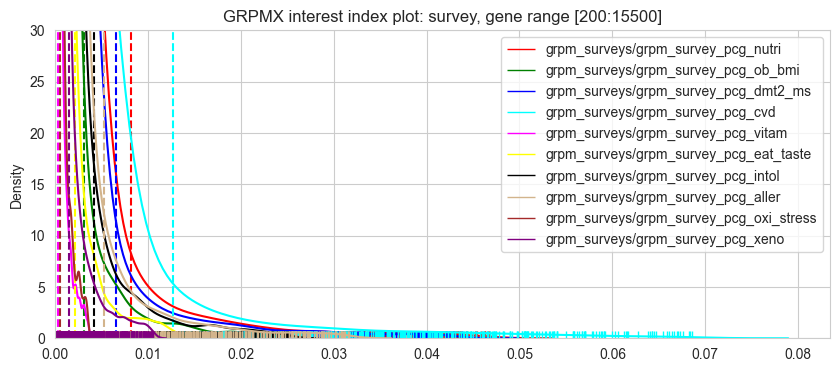

In [57]:
f_gene, l_gene = 200, 15500 # set gene-range for survey_l
log_scale = False

color_labels = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', '#D2B48C', '#A52A2A', '#800080']
color_labels = color_labels[:survey_l]
max_y = 0
plt.figure(figsize=(10, 4))
for n, i, col in zip(range(survey_l),
                     directories[:survey_l],
                     color_labels):
    dat = repo_int_sort_list[n].interest_index.iloc[f_gene:l_gene]

    sns.set_style('whitegrid')
    sns.kdeplot(np.array(dat), color = col, bw_method=0.5)
    sns.rugplot(np.array(dat), color = col, label=directories[n])
    # Add vertical line for the 95th percentile
    percentile_95 = dat.quantile(0.95)
    plt.axvline(x = percentile_95, color= col, linestyle='--')#, label='95th percentile')

    #density = sns.kdeplot(np.array(dat)).get_lines()[0].get_data()
    #if max(density[1]) > max_y:
    #    max_y = max(density[1])

#plt.yscale('log')
plt.title('GRPMX interest index plot: survey, gene range ['+str(f_gene)+':'+str(l_gene)+']')
plt.xlim(0)
plt.ylim(0, 30)
if log_scale:
    plt.yscale('log')
plt.legend()
print('GRPMX interest index plot:',' survey')#, directories[n])
plt.show()

In [ ]:
print('Statistics:')
f_gene, l_gen2 = 0, len(repo_list[0])
for i in range(len(directories)):
    repost = repo_int_sort_list[i]
    grpm_out = grpm_out_list[i]

    dir = master_df.directories[i]
    print(dir   ,'- int_index mean:',round(repost.interest_index.iloc[first:last].mean(), 6))
#GRPMX_report_int_7_sort.gene

In [ ]:
#Sort for interest index -------------
gene_l = 10
dff = pd.DataFrame()
for repo, dir in zip(repo_int_sort_list[:survey_l],directories[:survey_l]):
    dff[dir.replace('grpm_survey_pcg_','')] = repo.gene[:gene_l]
print('quick overview on top',gene_l,'genes on survey reports')
dff

## Density plot: GRPMX repo

In [ ]:
repo_int_sort_list[1][repo_int_sort_list[1].interest_index >= 0.0055]
master_df_ref

In [ ]:
## Survey Density Rugged Plot
# set gene range:
f_gene, l_gene = 200, 15500#, 20000
f_gene, l_gene = 0, 1000#, 20000

#set interest threshold
int_val_thershold = None #0.005 # interest value
int_ind_thershold = 0.0136 # interest index
log_scale = True
if 'survey_l' not in globals():
    survey_l = len(pd.Series(directories)[pd.Series(directories).str.contains('survey')])

datas_names = ['data_'] * 10
datas_names = [string + str(i+1) for i, string in enumerate(datas_names)]

datas = []
for name, repo in zip(datas_names,
                      repo_int_sort_list):
    dataframe = repo.interest_index.iloc[f_gene:l_gene]
    globals()[name] = dataframe
    datas.append(dataframe)

color_labels = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', '#D2B48C', '#A52A2A', '#800080']
color_labels = color_labels[0:survey_l]
start, end = 0, survey_l

plt.figure(figsize=(10, 4))
#plot randoms in grey
for dat in datas[survey_l+1:]:
    sns.set_style('whitegrid')
    sns.kdeplot(np.array(dat), bw_method=0.5, color='#808080')
    sns.rugplot(np.array(dat), color='#808080')

import re
def replace_after_and(string):
    pattern = r'and.*$'
    if string == 'Vitamin and Micronutrients Metabolism and Deficiency-Related Diseases':
        replaced_string = 'Vitamins and Micronutrients'
    else:
        replaced_string = re.sub(pattern, '', string)
    return replaced_string

#plot survey above in color
for dat, col, tag  in zip(datas[0:survey_l],
                          color_labels,
                          master_df.label[0:survey_l]):
    sns.set_style('whitegrid')
    sns.kdeplot(np.array(dat), bw_method=0.5, color=col, label= replace_after_and(tag) )
    sns.rugplot(np.array(dat), color=col)

if int_val_thershold is not None:
    plt.axvline(x = int_val_thershold, color= 'red', linestyle='--', label= 'threshold')
plt.axvline(x = int_ind_thershold, color= 'green', linestyle='--', label= 'threshold')

plt.title('GRPMX interest index plot: survey, gene range ['+str(f_gene)+':'+str(l_gene)+']')#, directories[n])
if log_scale:
    plt.xscale('log')
plt.ylim(0, 19)
#plt.xlim(0)
plt.legend()
print('\nGRPMX gene interest value desity plot:')
frame = {'directory': directories[start:len(color_labels)], 'color code':color_labels}
print(pd.DataFrame(frame))
plt.show()

## Density plot: GRPMX repo - General

In [ ]:
#settings-----
aggregate_randoms = True

#set interest threshold
int_val_thershold = None # 0.005 # interest value
int_ind_thershold = 0.0136 # interest index
log_scale = True
#survey_l = len(pd.Series(directories)[pd.Series(directories).str.contains('survey')])
#-------------

#full plot
datas_name = ['data_'] * 28
datas_name = [string + str(i+1) for i, string in enumerate(datas_name)]
start, end = 0, len(datas_name)

# gene list slice:
f_gene, l_gene = 0, 200#, 20000
f_gene, l_gene = 0, 850#, 20000
def slice_int(df):
    df_int_slice = df.interest_index.iloc[f_gene:l_gene]
    return df_int_slice

# Choose dataset to compare, slice datas list:
datas = []
for directory, name, repo in zip(directories[start:end],
                                 datas_name[start:end],
                                 repo_int_sort_list[start:end]):
    dataframe = slice_int(repo)
    globals()[name] = dataframe
    datas.append(dataframe)

# set survey series from master_df
survey_l = len(master_df[master_df.directories.str.contains('survey')])
color_labels = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', '#D2B48C', '#A52A2A', '#D8BFD8']
color_labels = color_labels[:survey_l]

if len(datas[survey_l+1:end]) != 0:
    cluster_rand = pd.concat(datas[len(color_labels)+1:end], axis=1)

# Desity Rugged Plot--------------------------
plt.figure(figsize=(10, 4))

#plot randoms in grey
if len(datas[survey_l+1:end]) != 0:
    if aggregate_randoms == True:
        dat = cluster_rand.mean(axis=1)
        sns.set_style('whitegrid')
        sns.kdeplot(np.array(dat), bw_method=0.5, color='#808080')
        sns.rugplot(np.array(dat), color='#808080', label='random mean')
    else:
        for dat in datas[survey_l+1:end]:
            sns.set_style('whitegrid')
            sns.kdeplot(np.array(dat), bw_method=0.5, color='#808080')
            sns.rugplot(np.array(dat), color='#808080')

#plot survey above in color
for dat, col, tag in zip(datas[start:survey_l],
                         color_labels,
                         master_df.short_labels[start:survey_l]):
    sns.set_style('whitegrid')
    sns.kdeplot(np.array(dat), bw_method=0.5, color=col)
    sns.rugplot(np.array(dat), color=col, label=tag)

if int_val_thershold is not None:
    plt.axvline(x = int_val_thershold, color= 'red', linestyle='--', label= 'threshold')
plt.axvline(x = int_ind_thershold, color= 'green', linestyle='--', label= 'threshold')

plt.title('GRPMX gene interest value desity plot (with '+str(random_l)+' clustered randoms), top '+str(l_gene)+' genes')
if log_scale:
    plt.xscale('log')
plt.ylim(0, 19)
#plt.xlim(0)#(10 ** -2.3)
plt.legend()

print('GRPMX gene interest value desity plot:')
#frame = {'directory': directories[start:end], 'color code':color_labels[start:end]}
frame = {'directory': directories[start:survey_l], 'color code':color_labels}
print(pd.DataFrame(frame))
plt.show()

## Plotting comparison over Master reference mesh

In [ ]:
master_df_ref

### Scatter Plotting

In [ ]:
# Burn all dataframes on master ref ----------------------------------------
genes_l = 50 #set master top genes to analyze
print('Choose master gene ref from master_df')
mast = int(input(master_df.label[:survey_l])) #4 #choose master gene ref from master_df

#def select_master_ref():
master_genes_repo = master_df.directories.iloc[mast]
master_genes = repo_int_sort_list[mast][:genes_l].gene
len(master_genes)

#slice all report for master_genes

def master_sampler(df):
    df_int_master_sample = df[df.gene.isin(master_genes)]
    return df_int_master_sample

master_list_names = [term + '_master' for term in report_int_names]
master_list_names = master_list_names[first:last]
master_df['master_list_names'] = master_list_names
print('master gene ref:', master_genes_repo)

# Choose dataset to compare, slice datas list:
#start, end = 0, 22
start, end = first, last
master_list = []
for directory, name, repo in zip(directories[start:end],
                                 master_list_names[start:end],
                                 repo_int_sort_list[start:end]):
    dataframe = master_sampler(repo)
    globals()[name] = dataframe
    master_list.append(dataframe)
    #print(name,'df mastered')
#---------------------------------------------------------

# set referece dataframe
referece = master_list[mast].copy()
referece['gene_id'] = range(1, len(referece) + 1)
gene_id_df = referece[['gene','gene_id']]
master_list[mast].gene.nunique()

# merge gene id into all dataframes
def merge_id(df):
    df_int_master_merge = pd.merge(df, gene_id_df, on='gene', how='left')
    return df_int_master_merge
print('')

# Choose dataset to compare, slice datas list:
new_master_list = []
for name, repo in zip(master_list_names, master_list):
    dataframe = merge_id(repo)
    globals()[name] = dataframe
    new_master_list.append(dataframe)
    #print(name,'df mastered with gen id')
print('all repo mastered')

#new_master_list[1]#.gene_id.nunique()
#----------------------------------------------------------------
#----------------------------------------------------------------

#Scatter Plotting

# select special_list from master_df to plot with master list
use_special_list = True
choose_compare = input('choose which lists to plot with: \n1. all lists\n2. group I (1,2,3)\n3. goup II (4,5,6,7,8,9)')
if choose_compare == '1':
    select_dirs = list(range(survey_l))
elif choose_compare == '2':
    select_dirs = [1,2,3]
else:
    select_dirs = [4,5,6,7,8,9]
if mast in select_dirs:
    select_dirs.remove(mast)
select_dirs

#plot randoms?
plot_random = simple_bool("Do you want to plot also randoms?")

# set survey series from master_df
survey_ser = master_df[master_df.directories.str.contains('survey')]
special_list = survey_ser # base value
survey_l = len(special_list)
random_ser = master_df[master_df.directories.str.contains('random')]
random_ser_num = len(random_ser)

color_labels = ['green', 'blue', 'cyan', 'magenta', '#FFA500', 'black', '#D2B48C', '#A52A2A', '#D8BFD8']
color_labels = color_labels[:survey_l]

dir_select = []
new_master_list_select = []
if use_special_list:
    master = [new_master_list[index] for index in select_dirs]
    dire = [master_df.directories[index] for index in select_dirs]
    new_master_list_select.extend(master)
    dir_select.extend(dire)
else:
    new_master_list_select = new_master_list[2:survey_l]
    dir_select = directories[2:survey_l]


# Desity Rugged Plot
plt.figure(figsize=(12, 6))

# plot master series in red:
x = new_master_list[mast].gene#_id
y = new_master_list[mast].interest_index
plt.scatter(x, y,  color='red', label=master_df.short_labels[mast]+' (Reference)')

if plot_random == True:
    #plot randoms in grey
    start, end = len(directories)-random_ser_num, len(directories)
    for dat in new_master_list[start:end]:
        # Create the dot plot using Seaborn
        x= dat.gene#_id
        y = dat.interest_index
        # Plot the first series
        plt.scatter(x, y, color='#808080')

#plot surveys in color:
for dat, col, dir in zip(new_master_list_select,
                         color_labels[:len(new_master_list_select)],
                         [master_df.short_labels[index] for index in select_dirs]):
    x = dat.gene#_id
    y = dat.interest_index
    plt.scatter(x, y,  color=col, label=dir)#.replace('grpm_survey_pcg_','mesh list: '))

# replot master series in red (to highlight):
x = new_master_list[mast].gene#_id
y = new_master_list[mast].interest_index
plt.scatter(x, y,  color='red')

# Set plot title and labels
if plot_random:
    plt.title('GI for top '+str(genes_l)+' genes in "'+master_df.label.iloc[mast]+'"\n Comparison with other MeSH lists (random lists included)')
else:
    plt.title('GI for top '+str(genes_l)+' genes in "'+master_df.label.iloc[mast]+'"\n Comparison with other MeSH lists')

plt.xticks(rotation=90)
#plt.tight_layout()    # Ensures all labels and ticks are visible
#plt.ylim(10 ** -5)
plt.yscale('log')
#plt.xlabel('top '+str(genes_l)+' genes')
plt.ylabel('GI')
plt.legend()

# Show the plot
print('GRPMX interest index plot:')
frame = {'directory': dir_select[:len(select_dirs)], 'color code':color_labels[:len(select_dirs)]}
print(pd.DataFrame(frame))

print(mast)
plt.savefig(r'G:\Altri computer\Razor\Nutrigenetica\Pubs_ourPaper\PaperRevision\Figures\plot1'+master_df.label.iloc[mast]+'.png', dpi=300)
plt.show()
print('''Figure 3 shows the top 50 genes with the highest value of interest on the "vitamin and micronutrient metabolism" list compared to the values of interest on 5 other nutritional Mesh term lists used. The analysis shows that genes extracted using the GRPM system show specificity for the list of Mesh terms used as a reference model. This suggests that the GRPM system demonstrated a good ability to identify genes related to that particular nutritional aspect. However, it is observable that some genes show significant interest on other Mesh term lists than the one taken as a reference. This phenomenon indicates the presence of genes that are more closely associated with other nutritional features or specific biological processes. This observation suggests the complexity of gene regulation in the context of nutrient metabolism and underscores the importance of considering a broader range of nutritional Mesh terms to gain a comprehensive understanding of the biological system under consideration.
''')

### Boxplotting randoms

#### gene symbol

In [ ]:
# prepare data -----------------
survey_ser = master_df[master_df.directories.str.contains('survey')]
survey_l = len(survey_ser)

# group all random interest index data:
new_df = pd.DataFrame(columns= ['gene','gene_id', 'interest_index'])

start, end = len(directories) - random_ser_num, len(directories)
for dat in new_master_list[start:end]:
    new_df = pd.concat([new_df, dat[['gene','gene_id', 'interest_index']]],axis=0)

# plotting data -----------------
plt.figure(figsize=(12, 6.5))

# Data for scatter plot
x_scatter = new_master_list[mast].gene
y_scatter = new_master_list[mast].interest_index
# Plot scatter:
plt.scatter(x=x_scatter, y=y_scatter, color='red', label= master_df.short_labels[mast]+' (Reference)')
plt.scatter(x=0, y=0, color='white',marker='s', edgecolor='black', label= 'Aggregated Randoms')

# Plot randoms:
if random_ser_num != 0:
    # Data for boxplot
    x_box = new_df.sort_values(by='gene_id', ascending=True).gene
    y_box = new_df.sort_values(by='gene_id', ascending=True).interest_index
    # Plot boxes
    sns.boxplot(x=x_box, y=y_box)

# Set the tick locations and labels
plt.xticks(rotation=90)
plt.yscale('log')
#plt.tight_layout()    # Ensures all labels and ticks are visible
#plt.ylim(10 ** -5)

plt.title('GI for top '+str(genes_l)+' genes in "'+master_df.label.iloc[mast]+'": scatter plot \n Aggregated GI value from 21 random MeSH lists: boxpot')
plt.ylabel('GI')
#plt.xlabel('top '+str(genes_l)+' genes')
plt.legend()
plt.savefig(r'G:\Altri computer\Razor\Nutrigenetica\Pubs_ourPaper\PaperRevision\Figures\figure1'+master_df.label.iloc[mast]+'.png', dpi=300)
plt.show()
print('''Comparing with Random MeSH Lists
To ensure the accuracy and reliability of the data collected, we compared the results obtained with biologically consistent mesh lists with those obtained with all random MeSH lists.
''')

#### numerical index (old version)

In [ ]:
# group all random interest index data:
new_df = pd.DataFrame(columns= ['gene','gene_id', 'interest_index'])
survey_ser = master_df[master_df.directories.str.contains('survey')]
survey_l = len(survey_ser)

#start, end = len(survey_ser)+1, len(directories)
start, end = len(directories)-random_ser_num, len(directories)
for dat in new_master_list[start:end]:
    new_df = pd.concat([new_df, dat[['gene','gene_id', 'interest_index']]],axis=0)

#Boxplotting:----------------
#set num of genes to plot
slice = 50
new_df_slice = new_df[new_df.gene_id <= slice]

if random_ser_num != 0:
    # Data for boxplot
    x_box = new_df_slice.gene_id
    y_box = new_df_slice.interest_index
    x_box_cat = pd.Categorical(x_box) # Convert x_box to categorical data

# Data for scatter plot
mast = mast
x_scatter = new_master_list[mast][new_master_list[mast].gene_id <= slice].gene_id
y_scatter = new_master_list[mast][new_master_list[mast].gene_id <= slice].interest_index
x_scatter_cat = pd.Categorical(x_scatter) # Convert x_scatter to categorical data


plt.figure(figsize=(12, 8))
if random_ser_num != 0:
    # Plot boxplot
    sns.boxplot(x=x_box_cat.codes, y=y_box)

# Plot scatter plot
plt.scatter(x=x_scatter_cat.codes, y=y_scatter, color='red', label= master_df.short_labels[mast]+' (Reference)')

plt.title('Gene Interest Index plot for survey VS all randoms GI aggregated as boxpot, top '+str(genes_l)+' genes')
plt.yscale('log')
plt.legend()

# Show the plot
plt.show()

# [Section 3]

# Analyze GRPM Reports

## Visualize GRPM_db report

In [ ]:
# Matching PMIDs in Database
sort_by = 'pubmed_pmid'
GRPM_report_sort = GRPM_report.sort_values(by= sort_by,ascending=False)
GRPM_report_sort[['gene','pubmed_pmid']]

In [ ]:
print('Sorted by: ', sort_by)
y_axis = 'pubmed_pmid'
x = GRPM_report_sort.gene.iloc[:40]
y = GRPM_report_sort[y_axis].iloc[:40]
plt.figure(figsize=(4, (len(x)*0.25)))
plt.title('PMIDs in Database\n sorted by '+sort_by, loc='center',pad=10)

plt.barh(x,y, color='#0483ff')
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('genes')
plt.xlabel(y_axis, position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.show()
#plt.savefig(r'C:\Users\Public\Database_SSD\GRPX_heavyload (RunOnly)\logs\Database_Gene('+str(len(GRPMX_report.gene))+')-PMID_filtered.png',dpi=300, bbox_inches = "tight")

In [ ]:
#LOG GET-----------------------------------------------------
genes_len = len(pd.read_csv('human_genes_repo/H_GENES_proteincoding_genes.csv'))
genes_found = len(GRPM_report)
print('\nLOG of base grpm database building:','\ngene query survey_l:',genes_len)
print('genes_found:',genes_found, round(genes_found/genes_len, 2))
print('no results on:')
litvar= 3481 #taken form Console LOG notes
litvar2= 346 #taken form Console LOG notes
litvar1= 3135 #taken form Console LOG notes
nbib= 236 #taken form Console LOG notes
print('litvar:',litvar, round(litvar/genes_len, 2),
      '\n   litvar2:',litvar2, round(litvar2/genes_len, 2),
      '\n   litvar1:',litvar1, round(litvar1/genes_len, 2),
      '\nnbib:',nbib, round(nbib/genes_len, 2))

In [ ]:
master_df_ref

In [ ]:
# Visualize GRPMX_report
n = 0
grpmx_report_00 = repo_int_sort_list[n]
print(type(grpmx_report_00['matching_mesh_ratio'][0]))
print('GRPMX_report table:')
#pyperclip.copy(str(GRPMX_report.columns))
len(grpmx_report_00.gene)
grpmx_report_00

In [ ]:
# Sort Short GRPMX_report
sort = 'interest_index'
print('GRPMX_report table ''sorted by '+sort+':')
grpmx_report_00_sort = grpmx_report_00.sort_values(by= sort,ascending=False).reset_index(drop=True)

grpmx_report_00[['gene', 'matching_pmidmesh', 'matching_pmids','matching_mesh', 'matching_rsid', 'dropped_rsid', 'matching_mesh_ratio','matching_pmids_ratio', 'matching_pmidmesh_ratio','matching_rsid_ratio', 'matching_rsid_pmid10', 'matching_rsid_pmid100','matching_pmids_index','interest_index','matching_top10mesh', 'matching_top10rsid']]#.to_clipboard() #to excel

### Defining Database most studied genes


In [ ]:
print('Full DB report')
GRPM_report[['gene','pubmed_pmid']].sort_values(by='pubmed_pmid', ascending = False).reset_index(drop=True)#.columns

In [ ]:
# create Bar Diagram
sort_by = 'pubmed_pmid'
GRPM_report_sort = GRPM_report.sort_values(by= sort_by,ascending=False)

gene_f = 0
gene_l = len(GRPM_report_sort.gene)
if gene_l > 30:
    gene_l = 30
y_axis = 'pubmed_pmid'
x = GRPM_report_sort.gene.iloc[gene_f:gene_l]
y = GRPM_report_sort[y_axis].iloc[gene_f:gene_l]
plt.figure(figsize=(4, (gene_l-gene_f)*0.20))
plt.title('Gene associated PMIDs in Database\n sorted by '+sort_by, loc='center',pad=10)

plt.barh(x,y)
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('genes')
plt.xlabel(y_axis, position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
#plt.savefig(r'C:\Users\Public\Database_SSD\GRPX_heavyload (RunOnly)\logs\Database_Gene('+str(len(GRPMX_report.gene))+')-PMID_filtered.png',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
# DENSITY PLOT
sort = 'pubmed_pmid'
data = GRPM_report_sort[sort].iloc[:100]

sns.set_style('whitegrid')
sns.kdeplot(np.array(data), bw_method=0.5)
sns.rugplot(np.array(data), color='r')

#plt.yscale('log')
plt.title('pubmed pmid density')
#plt.yscale('log')
plt.show()

### Defining pmid number threshold in GRPM DB

In [ ]:
# Definining pmid number treshold (GRPM DB)-------------------------------
thr_pmid_1 = 7
#thr_pmid_2 = 150
upper = 8000

thr_pmid_3 = 1
upper_2 = thr_pmid_1-1

threshold_GRPM_report_sort_1 = GRPM_report_sort[(GRPM_report_sort['pubmed_pmid']>=thr_pmid_1) & (GRPM_report_sort['pubmed_pmid']<=upper)].reset_index(drop=True)

#threshold_GRPM_report_sort_2 = GRPM_report_sort[(GRPM_report_sort['pubmed_pmid']>=threshold_2) & (GRPM_report_sort['pubmed_pmid']<=upper)].reset_index(drop=True)

threshold_GRPM_report_sort_3 = GRPM_report_sort[(GRPM_report_sort['pubmed_pmid']>=thr_pmid_3) & (GRPM_report_sort['pubmed_pmid']<=upper_2)].reset_index(drop=True)


#pyperclip.copy(str(threshold)+' '+ str(len(threshold_GRPM_report_sort)))
print('threshold by pmid number:')
print(len(threshold_GRPM_report_sort_3),'genes has <',thr_pmid_1, 'pmid')
print(len(threshold_GRPM_report_sort_1),' genes has >',thr_pmid_1, 'pmid')
threshold_GRPM_report_sort_1

In [ ]:
pyperclip.copy(str(threshold_GRPM_report_sort_1.gene.sample(200).to_list()))

In [ ]:
# DENSITY PLOT THRESHOLD
data = threshold_GRPM_report_sort_1.pubmed_pmid.iloc[:100]

sns.set_style('whitegrid')
sns.kdeplot(np.array(data), bw_method=0.5)
sns.rugplot(np.array(data), color='r')

#plt.yscale('log')
plt.title('pubmed pmid')
#plt.yscale('log')
plt.show()

## Visualize GRPM_survey reports

### Defining interesting genes
#### Comparison: ratio Vs Interest index

In [ ]:
master_df_ref

In [ ]:
# Comparison: matching_pmids_ratio Vs interest_index

#Set report to analyze
dir1 = 0 # choose from master_df
GRPMX_report_int = repo_int_sort_list[dir1]

# create Bar Diagram
sort_by = 'matching_pmids_ratio'
GRPMX_report_int_sort = GRPMX_report_int.sort_values(by= sort_by,ascending=False)
gene_f = 0
gene_l =   len(GRPMX_report_int_sort)
if gene_l  > 40:
    gene_l = 50
y_axis = 'interest_index'
x = GRPMX_report_int_sort.gene.iloc[:gene_l]
y = GRPMX_report_int_sort[y_axis].drop_duplicates().iloc[:gene_l]
plt.figure(figsize=(4, gene_l*0.20))
plt.title('Gene '+y_axis+ ':\n sorted by '+ sort_by, loc='center',pad=10)

plt.barh(x,y)
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('genes')
plt.xlabel(y_axis, position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
#plt.savefig(r'C:\Users\Public\Database_SSD\GRPX_heavyload (RunOnly)\logs\Database_Gene('+str(len(GRPMX_report.gene))+')-PMID_filtered.png',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
# create Bar Diagram
sort_by = 'matching_rsid_ratio'
GRPMX_report_int_sort = GRPMX_report_int.sort_values(by= sort_by,ascending=False)
print('Sorted by: ', sort_by)
gene_f = 0
gene_l =   len(GRPMX_report_int_sort)
if gene_l  > 30:
    gene_l = 50
y_axis = 'matching_rsid'
x = GRPMX_report_int_sort.gene.iloc[:gene_l]
y = GRPMX_report_int_sort[y_axis].drop_duplicates().iloc[:gene_l]
plt.figure(figsize=(4, gene_l*0.20))
plt.title('Matching rsid in Database\n sorted by '+sort_by, loc='center',pad=10)

plt.barh(x,y)
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('genes')
plt.xlabel(y_axis, position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.show()
#plt.savefig(r'C:\Users\Public\Database_SSD\GRPX_heavyload (RunOnly)\logs\Database_Gene('+str(len(GRPMX_report.gene))+')-PMID_filtered.png',dpi=300, bbox_inches = "tight")

In [ ]:
# Matching PMIDs in Database
sort_by = 'matching_pmids_index'
GRPMX_report_int_sort = GRPMX_report_int.sort_values(by= sort_by,ascending=False)
print('Sorted by: ', sort_by)
print('in ', directory)

gene_f , gene_l = 0, 0
gene_l =   len(GRPMX_report_int_sort)
if gene_l  > 30:
    gene_l = 50
y_axis = 'matching_pmids_index'
x = GRPMX_report_int_sort.gene.iloc[:gene_l]
y = GRPMX_report_int_sort[y_axis].drop_duplicates().iloc[:gene_l]
plt.figure(figsize=(4, gene_l*0.20))
plt.title('Matching PMIDs in Database\n sorted by '+ sort_by, loc='center',pad=10)

plt.barh(x,y)
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('genes')
plt.xlabel(y_axis, position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
#plt.savefig(r'C:\Users\Public\Database_SSD\GRPX_heavyload (RunOnly)\logs\Database_Gene('+str(len(GRPMX_report.gene))+')-PMID_filtered.png',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
# Matching PMIDs in Database
sort_by = 'interest_index'
GRPMX_report_int_sort = GRPMX_report_int.sort_values(by= sort_by,ascending=False)
print('Sorted by: ', sort_by)
print('in ', directory)
gene_f , gene_l, n = 0, 40, 1
gene_l =   len(GRPMX_report_int)
if gene_l  > 30:
    gene_l = 40
y_axis = 'interest_index'
x = GRPMX_report_int_sort.gene.iloc[gene_f*n:gene_l*n]
y = GRPMX_report_int_sort[y_axis].iloc[gene_f*n:gene_l*n]
plt.figure(figsize=(4, (gene_l-gene_f) * 0.20))
plt.title('Matching PMIDs in Database\n sorted by '+sort_by+'\n in'+directory, loc='center',pad=10)

plt.barh(x,y, color = '#04ade3')
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('genes')
plt.xlabel(y_axis, position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
#plt.savefig(r'C:\Users\Public\Database_SSD\GRPX_heavyload (RunOnly)\logs\Database_Gene('+str(len(GRPMX_report.gene))+')-PMID_filtered.png',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
# Matching PMIDs in Database

#Set report to analyze
n = 1
GRPMX_report_int_2 = repo_int_sort_list[n]

sort_by = 'interest_index'
GRPMX_report_int_2_sort = GRPMX_report_int_2.sort_values(by= sort_by,ascending=False)
print('Sorted by: ', sort_by)
print('in ', directories[n])
gene_f , gene_l, n = 0, 40, 1
gene_l =   len(GRPMX_report_int)
if gene_l  > 30:
    gene_l = 40
y_axis = 'interest_index'
x = GRPMX_report_int_sort.gene.iloc[gene_f*n:gene_l*n]
y = GRPMX_report_int_sort[y_axis].iloc[gene_f*n:gene_l*n]
plt.figure(figsize=(4, (gene_l-gene_f)*0.20))
plt.title('Matching PMIDs in Database\n sorted by '+sort_by+'\n in'+directories[n], loc='center',pad=10)

plt.barh(x,y, color = '#04ade3')
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('genes')
plt.xlabel(y_axis, position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
#plt.savefig(r'C:\Users\Public\Database_SSD\GRPX_heavyload (RunOnly)\logs\Database_Gene('+str(len(GRPMX_report.gene))+')-PMID_filtered.png',dpi=300, bbox_inches = "tight")
plt.show()

# Analyze GRPM survey output data

## Cooccurance matrix module

In [ ]:
#for i in range(len(directories)):
#    master_df.at[i, 'grpm_meshs'] = grpm_out_list[i].mesh.nunique()
master_df
grpm_out_list[0].columns

In [ ]:
# COOCCURANCE MATRIX MODULE------------

# choose value
value = 'gene'
# ['gene', 'rsid', 'pmids', 'mesh']
taglabel = 'short_labels' if custom_labels else 'tag'

# Assuming grpm_out_list is a list of objects and i is the index
lists = []
for i in range(len(grpm_out_list)):
    lists.append(set(grpm_out_list[i][value].to_list()))

# set the lists
num_lists = len(lists)

# Initialize a 2D list of zeros with dimensions equal to the number of lists
cooccur_matrix = [[0] * num_lists for i in range(num_lists)]
type(cooccur_matrix)
print(len(set(lists[1]) & set(lists[1])))
print(len(set(lists[1]) & set(lists[3])))

# Loop over all pairs of lists and count the number of co-occurring elements
for i in range(num_lists):
    for j in range(num_lists):
        if i == j:
            cooccur_matrix[i][j] = len(lists[i])
        else:
            cooccur_matrix[i][j] = len(set(lists[i]) & set(lists[j]))

# Convert the 2D list to a Pandas DataFrame
cooccur_df = pd.DataFrame(cooccur_matrix,
                          columns=[i for i in master_df[taglabel]],
                          index=[i for i in master_df[taglabel]]
                          )
                          #columns=['grpm{}'.format(i+1) for i in range(num_lists)],
                          #index=['grpm{}'.format(i+1) for i in range(num_lists)])

# Print the resulting DataFrame
cooccur_df.to_clipboard()
cooccur_df.columns
print('Cooccurrance Matrix: '+value)

sub_cooccur_df = cooccur_df.iloc[:,:survey_l][:survey_l]
sub_cooccur_df

In [ ]:
# Heatmap: 'max value'/row ------------------
plt.clf()
fig, ax = plt.subplots()

# Iterate over each row and plot individually
for i, row in enumerate(sub_cooccur_df[:survey_l].values):
    row_values = row.astype(float)  # Convert string values to floats
    max_value = np.max(row_values)  # Calculate the maximum value for the current row
    heatmap = ax.imshow([row_values],
                        cmap = 'YlGnBu',
                        vmax = max_value,
                        aspect = 'auto',
                        extent = [-0.5, len(row)+0.5, i+0.5, i-0.5])
                        #extent=[-0.5, len(row)-0.5, i-0.5, i+0.5])
    ax.text(len(row)-0.1, i,
            #f"{max_value:.2f}"
            f"{max_value}",
            ha='left',
            va='center')

# Add colorbar
cbar = plt.colorbar(heatmap)

# Set the tick labels and axis labels
ax.set_xticks(np.arange(sub_cooccur_df[:survey_l].shape[1]))
ax.set_yticks(np.arange(sub_cooccur_df[:survey_l].shape[0]))
ax.set_xticklabels(list(master_df[taglabel][:survey_l]), rotation=45, ha='right')
ax.set_yticklabels(list(master_df[taglabel][:survey_l]))

# Set the axis labels
#ax.set_xlabel('Columns')
#ax.set_ylabel('Rows')

# Set the title
ax.set_title('Occurrence Matrix: ' + value)

# Show the plot
plt



BHM: at which point the scale must be updated accordingly? I mean, you scale the values and you end up with a range [0,1]

User: scaling all the rows to their maximum by having [0,1] values for each row would also simplify the code for the heatmap although we would leave behind the differences in the numeric data. I can do this

'what is synoptic must be comparable.' BHM quote


In [ ]:
# modify coocur matrix with range [0,1]----
sub_cooccur_df.to_clipboard()
sub_cooccur_df_normalized = sub_cooccur_df.div(sub_cooccur_df.max(axis=1), axis=0) #div()= divide

sub_cooccur_df_normalized.to_clipboard()

#Overral values----------------------------
plt.clf()
#Create a figure and axis
fig, ax = plt.subplots()

#Create the heatmap
heatmap = ax.imshow(sub_cooccur_df_normalized[:survey_l], cmap='YlGnBu')

#Add colorbar
cbar = plt.colorbar(heatmap)

#Set the tick labels and axis labels
ax.set_xticks(np.arange(sub_cooccur_df_normalized[:survey_l].shape[1]))
ax.set_yticks(np.arange(sub_cooccur_df_normalized[:survey_l].shape[0]))
ax.set_xticklabels(list(master_df[taglabel][:survey_l]), rotation=45, ha='right')
ax.set_yticklabels(list(master_df[taglabel][:survey_l]))

#Set the axis labels
#ax.set_xlabel('Columns')
#ax.set_ylabel('Rows')

#Set the title
ax.set_title('Occurrence Matrix: '+value+' (normalized)')

#Show the plot
plt.show()

In [ ]:
#check
tag = 'ng_oxi_stress'
ref = pd.read_csv('ref-mesh-archive/ref_mesh_'+tag+'.csv')
ref['Preferred Label'].drop_duplicates()

In [ ]:
if simple_bool('trial?'):
    # Function to highlight cells
    def highlight_cell(x):
        color = 'background-color: yellow'
        return color

    # Apply styling to the DataFrame
    styled_df = cooccur_df.style.apply(highlight_cell)

    # Display the styled DataFrame
    styled_df

## Apply GI threshold to GRPM data

In [ ]:
master_df_ref

#### (1) thresholding all surveys report

In [19]:
# def thresholding function
thr_val_f = 0.0055
thr_int_f = 0.0125 #0.0139 #0.0130
filter_by = 'interest_value'
filter_by = 'interest_index'

#-----------------
if filter_by == 'interest_index':
    thr_f = thr_int_f
else:
    thr_f = thr_val_f

def thresholding(dataframe):
    output = dataframe[(dataframe[filter_by]>=thr_f) & (dataframe[filter_by]<=1)].reset_index(drop=True)
    return output

repo_thre_list = []
for repo, label in zip(repo_int_sort_list,
                       master_df.tag):
    dataframe = thresholding(repo)
    #globals()[name] = dataframe
    repo_thre_list.append(dataframe)
    #print(label,'df thresholded')

if 'interesting genes' in comp_df_stat_all.columns and ('genes_int_'+str(thr_f)) in comp_df_stat_all.columns:
    comp_df_stat_all.drop(['interesting genes', 'genes_int_'+str(thr_f)], axis=1, inplace = True)

## extend comp_df_stat_all: ---------------
for i in range(len(comp_df_stat_all)):
    repo = repo_thre_list[i]
    comp_df_stat_all.loc[i, 'genes_int_'+str(thr_f)] = int(repo.gene.nunique())

print('Interesting genes based on', filter_by)
comp_df_stat_all['genes_int_'+str(thr_f)] = comp_df_stat_all['genes_int_'+str(thr_f)].astype(int)
comp_df_stat_all['interesting genes'] = comp_df_stat_all['genes_int_'+str(thr_f)]
comp_df_stat_all

NameError: name 'comp_df_stat_all' is not defined

#### (2) add interest index to grpm_out_list genes and sort it

In [ ]:
if 'grpm_out_int_sort' not in globals() and 'grpm_out_int_sort' not in locals():
    grpm_out_int_sort = []
    timea = datetime.now()
    for grpm, i  in zip(grpm_out_list, range(len(grpm_out_list))):
        ## grpm [gene, interstr index] to merge wit grpmx output
        #print('add interest index to grpmx_output', directories[dir1])
        small_dummy = repo_int_sort_list[i][['gene','interest_index']]

        #grpmx_out_merge = pd.merge(grpmx_out_1, small_dummy, left_on='gene', right_on='gene')
        grpmx_out_merge_sort = pd.merge(grpm, small_dummy,
                                        left_on='gene', right_on='gene').sort_values(
                by=['interest_index','rsid'],
                ascending =False).reset_index(drop=True)
        grpm_out_int_sort.append(grpmx_out_merge_sort)
    print('runtime:',datetime.now()-timea)
    display(grpm_out_int_sort[1])
else:
    display(grpm_out_int_sort[1])

In [ ]:
# add other thresolded dta to Stats df:
grpm_thre_list = []
for grpm_data, label in zip(grpm_out_int_sort,
                            master_df.tag):
    dataframe = thresholding(grpm_data)
    #globals()[name] = dataframe
    grpm_thre_list.append(dataframe)
    #print(label,'df thresholded')

#if 'interesting genes' in comp_df_stat_all.columns and ('genes_int_'+str(thr_f)) in comp_df_stat_all.columns:
#    comp_df_stat_all.drop(['interesting genes', 'genes_int_'+str(thr_f)], axis=1, inplace = True)

## extend comp_df_stat_all: ---------------
for i in range(len(comp_df_stat_all)):
    grpm_data = grpm_thre_list[i]
    comp_df_stat_all.loc[i, 'interesting rsID'] = int(grpm_data.rsid.nunique())
    comp_df_stat_all.loc[i, 'interesting PMID'] = int(grpm_data.pmids.nunique())
    comp_df_stat_all.loc[i, 'interesting MeSH'] = int(grpm_data.mesh.nunique())


print('Interesting rsID, PMID, MeSH based on', filter_by)
comp_df_stat_all[['interesting rsID',
                 'interesting PMID',
                 'interesting MeSH']] = comp_df_stat_all[['interesting rsID',
                                                        'interesting PMID',
                                                        'interesting MeSH']].astype(int)
comp_df_stat_all

In [ ]:
if simple_bool('Save complete Statistics?'):
    comp_df_stat_all.to_csv(survey_path+'Comp_df_STAT_all.csv')

#### (-) Build complete stat df

In [ ]:
comp_df_stat_all

In [ ]:
if not 'grpm_genes_95' in comp_df_stat_all.columns:
    # create grpm_genes_95
    for i in range(len(comp_df_stat_all)):
        df = grpm_out_int_sort[i]
        comp_df_stat_all.loc[i, 'grpm_genes_95' ] = df[df.interest_index >= comp_df_stat_all.percentile_95[i]].gene.nunique()

    comp_df_stat_all.grpm_genes_95 = comp_df_stat_all.grpm_genes_95.astype(int)

    comp_df_stat_all[0:10][['label','grpm_genes','genes_int_'+str(thr_f),'genes_95','grpm_genes_95','percentile_95']]#.to_clipboard()
else:
    display(comp_df_stat_all[11:][['label','tag','grpm_meshs','grpm_genes','genes_int_'+str(thr_f),'genes_95','percentile_95']])
    comp_df_stat_all[11:][['label','grpm_meshs','grpm_pmids','grpm_rsids','grpm_genes','genes_int_'+str(thr_f),'genes_95','percentile_95']].to_clipboard()

#add grpm_rsid to comp_df_stat_all

grpm_out_int_sort[3][['gene','interest_index']].drop_duplicates()

#### (3) filtering 'grpmx_output_full' with selected interesting genes

In [ ]:
# thresholding grpm_out_int_sort:
grpm_out_thre = []
for i in range(len(grpm_out_int_sort)):
    output = grpm_out_int_sort[i][grpm_out_int_sort[i].gene.isin(repo_thre_list[i].gene)]
    grpm_out_thre.append(output)

grpm_out_thre[7][['gene','interest_index']].drop_duplicates()

#### (-) side job: add gene unique to 'comp_df_stat'

In [ ]:
comp_df_stat_all[[taglabel,'grpm_genes','interesting genes']]

##### - single search overrall

In [ ]:
# single grpm search (nutri general excluded):
grpm_out_int_sort_sub = grpm_out_int_sort[:survey_l]

m = 2 # index from master_df
grpm_out_int_sort_sub_pop = grpm_out_int_sort_sub[:]

grpm_out_int_sort_sub_pop.pop(m) # pop index survey
grpm_out_int_sort_sub_pop.pop(0) # pop nutri

gene_overrall_list_pop = []
# all others genes
for df in grpm_out_int_sort_sub_pop:#range(len(grpm_out_int_sort_sub_pop)):
    #genes = grpm_out_int_sort_sub_pop[df].gene.drop_duplicates().to_list()
    genes = df.gene.drop_duplicates().to_list()
    gene_overrall_list_pop.extend(genes)

gene_overrall_list_pop_un = set(gene_overrall_list_pop)

filtered_df_all = grpm_out_int_sort_sub[m][~grpm_out_int_sort_sub[m]['gene'].isin(gene_overrall_list_pop_un)].dropna()

all_uniq = set(filtered_df_all.gene)
pd.Series(list(all_uniq)).to_clipboard()
#pd.Series(list(gene_overrall_list_pop_un)).to_clipboard()
#grpm_out_int_sort_sub[m].gene.drop_duplicates().to_clipboard()
print(filtered_df_all.gene.nunique(),'/',grpm_out_int_sort[m].gene.nunique())

#grpm_out_int_sort_sub_pop[1].gene.drop_duplicates().to_list()
filtered_df_all

##### - batch search overrall

In [ ]:
# batch grpm search (nutri general excluded):
grpm_out_int_sort_sub = grpm_out_int_sort[:survey_l]

print('Uniques genes overall** / total' )
for m in range(1, 10):
    grpm_out_int_sort_sub_pop = grpm_out_int_sort_sub[:]

    grpm_out_int_sort_sub_pop.pop(m) # pop index survey
    grpm_out_int_sort_sub_pop.pop(0) # pop nutri

    gene_overrall_list_pop = []
    # all others genes
    for df in grpm_out_int_sort_sub_pop:#range(len(grpm_out_int_sort_sub_pop)):
        #genes = grpm_out_int_sort_sub_pop[df].gene.drop_duplicates().to_list()
        genes = df.gene.drop_duplicates().to_list()
        gene_overrall_list_pop.extend(genes)
    gene_overrall_list_pop_un = set(gene_overrall_list_pop)

    filtered_df_all = grpm_out_int_sort_sub[m][~grpm_out_int_sort_sub[m]['gene'].isin(gene_overrall_list_pop_un)]

    print((master_df[taglabel][m]).ljust(20),filtered_df_all.gene.nunique(),'/',grpm_out_int_sort[m].gene.nunique())

master_df[['directories','grpm_genes']][:survey_l].to_dict()

Uniques genes overall** / total  :
  'grpm_survey_pcg_ob_bmi' :   196 / 9713,
  'grpm_survey_pcg_dmt2_ms' :  131 / 10983,
  'grpm_survey_pcg_cvd' :      698 / 12368,
  'grpm_survey_pcg_vitam' :     26 / 4045,
  'grpm_survey_pcg_eat_taste':  75 / 5525,
  'grpm_survey_pcg_intol' :     57 / 4040,
  'grpm_survey_pcg_aller' :     103 / 4681,
  'grpm_survey_pcg_oxi_stress':  31 / 5156,
  'grpm_survey_pcg_xeno'} :     176 / 7115,

##### - single search (interesting genes)

In [ ]:
# single grpm search (nutri general excluded):
grpm_out_thre_sub = grpm_out_thre[:survey_l]
len(grpm_out_thre_sub)
m = 7 # index from master_df

grpm_out_thre_sub_pop = grpm_out_thre_sub[:]

grpm_out_thre_sub_pop.pop(m)
grpm_out_thre_sub_pop.pop(0) # pop nutri

gene_overrall_list_pop = []
# all others genes
for df in grpm_out_thre_sub_pop:#range(len(grpm_out_int_sort_sub_pop)):
    #genes = grpm_out_thre_sub_pop[df].gene.drop_duplicates().to_list()
    genes = df.gene.drop_duplicates().to_list()
    #print(len(set(genes)))
    gene_overrall_list_pop.extend(genes)

gene_overrall_list_pop_un = set(gene_overrall_list_pop)

filtered_df = grpm_out_thre_sub[m][~grpm_out_thre_sub[m]['gene'].isin(gene_overrall_list_pop_un)]

#pd.Series(list(gene_overrall_list_pop_un)).to_clipboard()
#grpm_out_thre_sub[m].gene.drop_duplicates().to_clipboard()
min_uniq = set(filtered_df.gene)
pd.Series(list(min_uniq)).to_clipboard()
print((master_df[taglabel][m]).ljust(20),filtered_df.gene.nunique(),'/',grpm_out_thre_sub[m].gene.nunique())
filtered_df[['gene','interest_index']].drop_duplicates()

##### - batch search (interesting genes)

In [ ]:
# batch grpm search (nutri genral excluded):
grpm_out_thre_sub = grpm_out_thre[:survey_l]

print('Uniques genes (interesting, gi>=',thr_f,')/ total' )
for m in range(1, 10):
    grpm_out_thre_sub_pop = grpm_out_thre_sub[:]

    grpm_out_thre_sub_pop.pop(m)
    grpm_out_thre_sub_pop.pop(0) # pop nutri

    gene_overrall_list_pop = []
    # all others genes
    for df in grpm_out_thre_sub_pop:#range(len(grpm_out_int_sort_sub_pop)):
        #genes = grpm_out_thre_sub_pop[df].gene.drop_duplicates().to_list()
        genes = df.gene.drop_duplicates().to_list()
        #print(len(set(genes)))
        gene_overrall_list_pop.extend(genes)
    gene_overrall_list_pop_un = set(gene_overrall_list_pop)

    filtered_df = grpm_out_thre_sub[m][~grpm_out_thre_sub[m]['gene'].isin(gene_overrall_list_pop_un)]

    print((master_df[taglabel][m]).ljust(20),filtered_df.gene.nunique(),'/',grpm_out_thre_sub[m].gene.nunique())

LOG
redo on grpm_out_thre
Uniques genes int value thr 0.0055** / total  :
  'grpm_survey_pcg_ob_bmi' :    51 / 491
  'grpm_survey_pcg_dmt2_ms' :   54 / 658
  'grpm_survey_pcg_cvd' :       369 / 1064
  'grpm_survey_pcg_vitam' :     18 / 91
  'grpm_survey_pcg_eat_taste':  31 / 179
  'grpm_survey_pcg_intol' :     102 / 196
  'grpm_survey_pcg_aller' :     105 / 212
  'grpm_survey_pcg_oxi_stress': 2 / 82
  'grpm_survey_pcg_xeno'} :     101 / 309

Uniques genes (interesting) int index> 0.0136/ total
    Obesity & Weight     7 / 289
    Diabetes Type II     52 / 571
    Cardiovascular Hlth  288 / 903
    Vitamins & Minerals  21 / 85
    Eating Behavior      37 / 196
    Food Intolerances    185 / 363
    Food Allergies       267 / 423
    Oxidative Stress     2 / 73
    Xenobiotics Metab    34 / 158

Uniques genes (interesting, gi>= 0.0125 )/ total
    Obesity & Weight     9 / 317
    Diabetes Type II     56 / 603
    Cardiovascular Hlth  320 / 975
    Vitamins & Minerals  19 / 89
    Eating Behavior      36 / 211
    Food Intolerances    201 / 392
    Food Allergies       279 / 451
    Oxidative Stress     2 / 75
    Xenobiotics Metab    36 / 173


**(general nutri excluded)

#### (-) side job 2: thresholded genes on grpm with boolean>quant95

In [ ]:
comp_df_stat_all.percentile_95.iloc[1]
grpm_out_thre_sub[0]

#grpm_out_thre_sub_95 = []
for grpm, i  in zip(grpm_out_thre_sub, range(len(grpm_out_thre_sub))):
    grpm['>95'] = grpm['interest_index'] > comp_df_stat_all['percentile_95'].iloc[i]
    #grpm['>95'] = grpm['interest_index'] > comp_df_stat_all['percentile_95']
grpm_out_thre_sub[1]

In [ ]:
#only in 'Cardiovascular Diseases' boolean == False for some genes
print(grpm_out_thre_sub[3][grpm_out_thre_sub[3]['>95'] == False].nunique())
print(grpm_out_thre_sub[3][grpm_out_thre_sub[3]['>95'] == True].nunique())
print(grpm_out_thre_sub[3].nunique())
grpm_out_thre_sub[3][grpm_out_thre_sub[3]['>95'] == False]

#### (4) coocur matrix and visualise heatmap

In [ ]:
# COOCCURANCE MATRIX MODULE------------
# second matrix build check

# choose value
value = input("choose value: ['gene', 'rsid', 'pmids', 'mesh']")
# ['gene', 'rsid', 'pmids', 'mesh']

# Assuming grpm_out_list is a list of objects and i is the index
lists = []
for i in range(len(grpm_out_thre)):
    lists.append(set(grpm_out_thre[i][value].to_list()))

# set the lists
num_lists = len(lists)

# Initialize a 2D list of zeros with dimensions equal to the number of lists
cooccur_2_matrix = [[0] * num_lists for i in range(num_lists)]
type(cooccur_2_matrix)
#print(len(set(lists[1]) & set(lists[1])))
#print(len(set(lists[1]) & set(lists[3])))

# Loop over all pairs of lists and count the number of co-occurring elements
for i in range(num_lists):
    for j in range(num_lists):
        if i == j:
            cooccur_2_matrix[i][j] = len(lists[i])
        else:
            cooccur_2_matrix[i][j] = len(set(lists[i]) & set(lists[j]))

# Convert the 2D list to a Pandas DataFrame
cooccur_2_df = pd.DataFrame(cooccur_2_matrix,
                          columns=[i for i in master_df[taglabel]],
                          index = [i for i in master_df[taglabel]])
#columns=['grpm{}'.format(i+1) for i in range(num_lists)],
#index=['grpm{}'.format(i+1) for i in range(num_lists)])

# Print the resulting DataFrame
cooccur_2_df.to_clipboard()

print('Cooccurrance Matrix on interesting genes: '+ value)

sub_cooccur_2_df = cooccur_2_df.iloc[:,:survey_l][:survey_l]
display(sub_cooccur_2_df)

if simple_bool('create absolute heatmap (y) or normalized (n):'):
    # Row max values------------------
    fig, ax = plt.subplots()

    # Iterate over each row and plot individually
    for i, row in enumerate(sub_cooccur_2_df[:survey_l].values):
        row_values = row.astype(float)  # Convert string values to floats
        max_value = np.max(row_values)  # Calculate the maximum value for the current row
        heatmap = ax.imshow([row_values],
                            cmap='YlGnBu',
                            vmax=max_value,
                            aspect='auto',
                            extent=[-0.5, len(row)+0.5, i+0.5, i-0.5])
        ax.text(len(row)-0.1, i,
                f"{int(max_value)}",
                ha='left',
                va='center')

    # Add colorbar
    cbar = plt.colorbar(heatmap)

    # Set the tick labels and axis labels
    ax.set_xticks(np.arange(sub_cooccur_2_df[:survey_l].shape[1]))
    ax.set_yticks(np.arange(sub_cooccur_2_df[:survey_l].shape[0]))
    ax.set_xticklabels(list(master_df[taglabel][:survey_l]), rotation=45, ha='right')
    ax.set_yticklabels(list(master_df[taglabel][:survey_l]))

    # Set the title
    ax.set_title('Occurrence Matrix: ' + value+'\ninterest_index threshold: '+str(thr_f))

    # Show the plot
    plt.show()

else:
    # modify coocur matrix with range [0,1]----
    sub_cooccur_2_df.to_clipboard()
    sub_cooccur_2_df_normalized = sub_cooccur_2_df.div(sub_cooccur_2_df.max(axis=1), axis=0) #div()= divide

    sub_cooccur_2_df_normalized.to_clipboard()

    #Overral values----------------------------
    #Create a figure and axis
    fig, ax = plt.subplots()

    #Create the heatmap
    heatmap = ax.imshow(sub_cooccur_2_df_normalized[:survey_l], cmap='YlGnBu')

    #Add colorbar
    cbar = plt.colorbar(heatmap)

    #Set the tick labels and axis labels
    ax.set_xticks(np.arange(sub_cooccur_2_df_normalized[:survey_l].shape[1]))
    ax.set_yticks(np.arange(sub_cooccur_2_df_normalized[:survey_l].shape[0]))
    ax.set_xticklabels(list(master_df[taglabel][:survey_l]), rotation=45, ha='right')
    ax.set_yticklabels(list(master_df[taglabel][:survey_l]))

    #Set the title
    ax.set_title('Occurrence Matrix: ' + value+'\ninterest_index threshold: '+str(thr_f))

    #Show the plot
    plt.show()

## Definining ‘interest index’ threshold process

In [ ]:
# Definining ‘interest index’ threshold-----------------------------
thr_val_f = 0.0055
thr_int_f1 = 0.025
thr_int_f2 = 0.0136

dir1 = 8 # choose dir
dir2 = 9 # choose dir
repo_int_sort_1 = repo_int_sort_list[dir1]
repo_int_sort_2 = repo_int_sort_list[dir2]

threshold_GRPMX_report_int_sort = repo_int_sort_1[(repo_int_sort_1['interest_index']>=thr_int_f1) & (repo_int_sort_1['interest_index']<=1)].reset_index(drop=True)

print('thresholding',directories[dir1])
threshold_GRPMX_report_int_sort2 = repo_int_sort_1[(repo_int_sort_1['interest_index']>=thr_int_f2) & (repo_int_sort_1['interest_index']<=1)].reset_index(drop=True)
print('thresholding',directories[dir2])
threshold_GRPMX_report_int_2_sort2 = repo_int_sort_2[(repo_int_sort_2['interest_index']>=thr_int_f2) & (repo_int_sort_2['interest_index']<=1)].reset_index(drop=True)

print('threshold by \'interest index\':','\n  ', directories[dir1],'\n  ', directories[dir2])
#pyperclip.copy(str(threshold)+' '+ str(len(threshold_GRPMX_report_int_sort)))
threshold_GRPMX_report_int_sort2#.to_csv('threshold_GRPMX_report_int_sort.csv')#2#.to_clipboard()

#### filtering grpmx_output_full with selected interesting genes

In [ ]:
master_df

In [ ]:
#grpmx_out_1 = pd.read_csv(directories[dir1]+'/grpmx_filtered_output.csv',index_col=0)
#grpmx_out_2 = pd.read_csv(directories[dir2]+'/grpmx_filtered_output.csv',index_col=0)

# the same as grpm_out_list
grpmx_out_1 = grpm_out_list[dir1]
grpmx_out_2 = grpm_out_list[dir2]

In [ ]:
grpmx_out_1

In [ ]:
## grpm [gene, interstr index] to merge wit grpmx output
print('add interest index to grpmx_output', directories[dir1])
small_dummy = repo_int_sort_list[dir1][['gene','interest_index']]

#grpmx_out_merge = pd.merge(grpmx_out_1, small_dummy, left_on='gene', right_on='gene')
grpmx_out_merge_sort = pd.merge(grpmx_out_1, small_dummy, left_on='gene', right_on='gene')\
    .sort_values(by=['interest_index','rsid'], ascending =False).reset_index(drop=True)
grpmx_out_merge_sort

In [ ]:
## grpm [gene, interstr index] to merge wit grpmx output
print('add interest index to grpmx_output',directories[dir2])
small_dummy = repo_int_sort_list[dir2][['gene','interest_index']]
#grpmx_out_2_merge = pd.merge(grpmx_out_2, small_dummy, left_on='gene', right_on='gene')
grpmx_out_2_merge_sort = pd.merge(grpmx_out_2, small_dummy, left_on='gene', right_on='gene')\
    .sort_values(by=['interest_index','rsid'], ascending =False).reset_index(drop=True)
grpmx_out_2_merge_sort

In [ ]:
#Appling for thershold genes-------------------------------------
print('Appling "interest index" threshold',thr_int_f2,'on', directories[dir1])
grpmx_out_thr = grpmx_out_merge_sort[grpmx_out_merge_sort.gene.isin(threshold_GRPMX_report_int_sort2.gene)]
print('Appling "interest index" threshold',thr_int_f2,'on', directories[dir2])
grpmx_out_thr_2 = grpmx_out_2_merge_sort[grpmx_out_2_merge_sort.gene.isin(threshold_GRPMX_report_int_2_sort2.gene)]

print('')
print(directories[dir1], 'threshold',thr_int_f2,'applied')
print(grpmx_out_thr.gene.nunique(), 'genes')
print(grpmx_out_thr.rsid.nunique(), 'rsid with pmid with mesh')
print(grpmx_out_thr.mesh.nunique(), 'mesh')
print(round(grpmx_out_thr.rsid.nunique()/grpmx_out_thr.gene.nunique(), 0), 'risd for gene (mean)')
print ('Based on', repo_int_sort_list[dir1].reference_mesh[0], 'reference mesh terms')

print('')
print(directories[dir2], 'threshold',thr_int_f2,'applied')
print(grpmx_out_thr_2.gene.nunique(), 'genes')
print(grpmx_out_thr_2.rsid.nunique(), 'rsid with pmid with mesh')
print(grpmx_out_thr_2.mesh.nunique(), 'mesh')
print(round(grpmx_out_thr_2.rsid.nunique()/grpmx_out_thr_2.gene.nunique(), 0), 'risd for gene (mean)')
print ('Based on', repo_int_sort_list[dir2].reference_mesh[0], 'reference mesh terms')

In [ ]:
grpmx_out_thr_ngene = grpmx_out_thr.gene.nunique()
grpmx_out_thr_nrsid = grpmx_out_thr.rsid.nunique()
grpmx_out_thr_npmid = grpmx_out_thr.pmids.nunique()
grpmx_out_thr_nmesh = grpmx_out_thr.mesh.nunique()
print(directories[dir1])
print(grpmx_out_thr_ngene, 'genes')
print(grpmx_out_thr_nrsid, 'rsids')
print(grpmx_out_thr_npmid, 'pmids')
print(grpmx_out_thr_nmesh, 'meshs')
print('')
grpmx_out_thr_2_ngene = grpmx_out_thr_2.gene.nunique()
grpmx_out_thr_2_nrsid = grpmx_out_thr_2.rsid.nunique()
grpmx_out_thr_2_npmid = grpmx_out_thr_2.pmids.nunique()
grpmx_out_thr_2_nmesh = grpmx_out_thr_2.mesh.nunique()
print(directories[dir2])
print(grpmx_out_thr_2_ngene, 'genes')
print(grpmx_out_thr_2_nrsid, 'rsids')
print(grpmx_out_thr_2_npmid, 'pmids')
print(grpmx_out_thr_2_nmesh, 'meshs')

In [ ]:
# Analyze intersections
directory_2 = directories[dir2]
directory   = directories[dir1]

grpmx_thr_genes = grpmx_out_thr.gene.drop_duplicates()
grpmx_thr_rsids = grpmx_out_thr.rsid.drop_duplicates()
grpmx_thr_pmids = grpmx_out_thr.pmids.drop_duplicates()
grpmx_thr_meshs = grpmx_out_thr.mesh.drop_duplicates()
grpmx_thr_2_genes = grpmx_out_thr_2.gene.drop_duplicates()
grpmx_thr_2_rsids = grpmx_out_thr_2.rsid.drop_duplicates()
grpmx_thr_2_pmids = grpmx_out_thr_2.pmids.drop_duplicates()
grpmx_thr_2_meshs = grpmx_out_thr_2.mesh.drop_duplicates()

mask_gene_1 = grpmx_out_thr_2.gene.isin( grpmx_thr_genes)
mask_rsid_1 = grpmx_out_thr_2.rsid.isin( grpmx_thr_rsids)
mask_pmid_1 = grpmx_out_thr_2.pmids.isin(grpmx_thr_pmids)
mask_mesh_1 = grpmx_out_thr_2.mesh.isin( grpmx_thr_meshs)
mask_gene_2 = grpmx_out_thr.gene.isin(grpmx_thr_2_genes)
mask_rsid_2 = grpmx_out_thr.rsid.isin(grpmx_thr_2_rsids)
mask_pmid_2 = grpmx_out_thr.pmids.isin(grpmx_thr_2_pmids)
mask_mesh_2 = grpmx_out_thr.mesh.isin(grpmx_thr_2_meshs)

grpmx_out_thr_maskgene = grpmx_out_thr[mask_gene_2]
grpmx_out_thr_maskrsid = grpmx_out_thr[mask_rsid_2]
grpmx_out_thr_maskpmid = grpmx_out_thr[mask_pmid_2]
grpmx_out_thr_maskmesh = grpmx_out_thr[mask_mesh_2]
grpmx_out_thr_2_maskgene = grpmx_out_thr_2[mask_gene_1]
grpmx_out_thr_2_maskrsid = grpmx_out_thr_2[mask_rsid_1]
grpmx_out_thr_2_maskpmid = grpmx_out_thr_2[mask_pmid_1]
grpmx_out_thr_2_maskmesh = grpmx_out_thr_2[mask_mesh_1]

print(directory,'vs',directory_2)
print(grpmx_out_thr_maskgene.gene.nunique() ,  'genes intersection on', grpmx_out_thr_ngene)
print(grpmx_out_thr_maskrsid.rsid.nunique() ,  'rsid intersection on',  grpmx_out_thr_nrsid)
print(grpmx_out_thr_maskpmid.pmids.nunique(),  'pmid intersection on',  grpmx_out_thr_npmid)
print(grpmx_out_thr_maskmesh.mesh.nunique() ,  'mesh intersection on',  grpmx_out_thr_nmesh)
print('')
print(directory_2,'vs',directory)
print(grpmx_out_thr_2_maskgene.gene.nunique(), 'genes intersection on', grpmx_out_thr_2_ngene)
print(grpmx_out_thr_2_maskrsid.rsid.nunique(), 'rsid intersection on',  grpmx_out_thr_2_nrsid)
print(grpmx_out_thr_2_maskpmid.pmids.nunique(),'pmid intersection on',  grpmx_out_thr_2_npmid)
print(grpmx_out_thr_2_maskmesh.mesh.nunique(), 'mesh intersection on',  grpmx_out_thr_2_nmesh)
print('')
print('Overlapping index:')
print(round(grpmx_out_thr_maskgene.gene.nunique() /grpmx_out_thr_ngene*100,2),'%','genes overlap')
print(round(grpmx_out_thr_maskrsid.rsid.nunique() /grpmx_out_thr_nrsid*100,2),'%', 'rsid overlap')
print(round(grpmx_out_thr_maskpmid.pmids.nunique()/grpmx_out_thr_npmid*100,2),'%', 'pmid overlap')
print(round(grpmx_out_thr_maskmesh.mesh.nunique() /grpmx_out_thr_nmesh*100,2),'%', 'mesh overlap')

## Analyzing mesh on selected gene data

In [ ]:
# just top10mesh from grpm report

type(threshold_GRPMX_report_int_sort2['matching_top10mesh'][0])
import ast
# Define a function to convert a string to a list
def str_to_list(s):
    return ast.literal_eval(s)

mesh_exp = []
for i in range(len(threshold_GRPMX_report_int_sort2)):
    #for mesh in threshold_GRPMX_report_int_sort2['matching_top10mesh'].apply(str_to_list)[i]:
    for mesh in threshold_GRPMX_report_int_sort2['matching_top10mesh'].apply(ast.literal_eval)[i]:
        f = threshold_GRPMX_report_int_sort2['gene'][i], mesh
        mesh_exp.append(f)

gene_mesh = pd.DataFrame(mesh_exp)

In [ ]:
gene_mesh.columns = ['gene','mesh']
print('gene:', gene_mesh.gene.nunique())
print('mesh:', gene_mesh.mesh.nunique())

In [ ]:
contingency_table = pd.crosstab(gene_mesh['gene'], gene_mesh['mesh'])
contingency_table

In [ ]:
# groupby describe
gene_mesh_count = gene_mesh.groupby('mesh').describe().reset_index()
gene_mesh_count.columns = [('mesh_'),
                           ('gene_count'),
                           ('gene_unique'),
                           ('gene_top'),
                           ('gene_freq')]
gene_mesh_count.sort_values(by='gene_count', ascending =False).reset_index(drop=True)

In [ ]:
#get pmid number range for threshold_GRPMX_report_int_sort2
subset = threshold_GRPMX_report_int_sort2[['gene','starting_pmid','matching_pmids']]
subset_sort = subset.sort_values(by='starting_pmid', ascending = False).reset_index(drop=True)
print(len(threshold_GRPMX_report_int_sort2), 'filtered genes with threshold',thr_int_f2 )
print('    min matching pmid value: ', subset_sort.matching_pmids.min())
print('    min starting pmid value: ', subset_sort.starting_pmid.min())

pmid_num_db = GRPM_report_sort[GRPM_report_sort['pubmed_pmid'] >= subset_sort.starting_pmid.min()].count()['pubmed_pmid']
print(pmid_num_db, 'genes in GRPM db has >=', subset_sort.starting_pmid.min())
print( len(threshold_GRPMX_report_int_sort2),'genes filterd','over', pmid_num_db, 'equivalent genes in db')
subset_sort.gene.to_clipboard(index=False, header=False)

In [ ]:
# DENSITY PLOT THRESHOLD
data = threshold_GRPMX_report_int_sort.interest_index#.iloc[:100]

sns.set_style('whitegrid')
sns.kdeplot(np.array(data), bw_method=0.5)
sns.rugplot(np.array(data), color='r')

#plt.yscale('log')
plt.title('interest_index')
#plt.yscale('log')
plt.show()

# Positive and negative control
Truth table contructor


In [ ]:
master_df
repo_thre_list[1]

In [ ]:
#Truth table contructor:
if 'threshold_GRPMX_report_int_sort' in locals() or 'threshold_GRPMX_report_int_sort' in globals():
    genesthr01 = threshold_GRPMX_report_int_sort.gene
    genesthr02 = threshold_GRPMX_report_int_sort2.gene
else:
    genesthr01 = repo_thre_list[0]
    genesthr02 = repo_thre_list[1]
#genesthr03 = threshold_GRPMX_report_int_sort3.gene
#genesnewint = GRPMX_report_new_int.sort_values(by='new_interest_index',ascending=False).gene.iloc[:879]

genestesi = pd.Series(['ADIPOQ','ADRB1','ADRB3','APOA2','APOA5','DRD2','FTO','GHRL','GHSR','IL-1B','LEP','MC4R','NPY','PPARG','SLC6A4','ACE','ADRB2','AGT','AGTR1','APOA1','APOB','APOC3','APOE','CETP','CYBA','EDN1','F5','FGB','GJA4','HMGCR','LIPC','LPA','LPL','MMP3','MTHFR','NOS3','PON1','PPARA','PPARGC1A','PROCR','SELE','SREBF2','VEGF','FABP2','IRS1','LEPR','MTNR1B','TCF7L2','ALPL','BCO1','CBS','FADS1','FUT2','GC','MTR','MTRR','NBPF3','TCN2','VDR','ADD1','CD36','CYP11B2','SLC2A2','TAS2R38','ADH1B','ADH1C','ALDH2','ALDOB','AOC1','CYP1A2','HLA-DQA1','HLA-DQB1','HNMT','MCM6','EPHX1','G6PD','GPX1','GSTP1','GSTT1','SOD2','SOD3','SOUX','CRP','IL-10','IL-6','IL6R','TNF'])
genespnn = pd.Series(['ACE','ADH1B','ADIPOQ','ADRB2','ADRB3','AGT','ALDH2','APOA1','APOA2','APOB','APOC3','APOE','CBS','CD36','CETP','CRP','CYP11B2','CYP1A2','FTO','GC','GHSR','LEP','LEPR','LIPC','LPL','MTHFR','MTR','MTRR','NOS3','NPY','PPARA','PPARG','SLC2A2','SREBF2','TAS2R38','TCF7L2','TNF','VDR','ALDH1A2','FADS2','IL6','LTA','DRD2','MC4R','ABCA4','ABCB4','ABCC4','ABCG2','ABCG5','ABCG8','ACHE','ACSL5','ACTN3','ADCY3','ADH4','ADORA2A','ADRA2B','AGPAT2','AGRP','ALDH1A3','APOA4','AR','ARC','ATF4','ATP2A1','ATP7A','ATP7B','BCDIN3D','BDNF','BGLAP','BHMT','BIRC7','BMP6','BSCL2','BTG2','BUD13','C1S','C2','C2orf69','C3','C4orf46','C5','C7','C9','CALU','CAV2','CCDC50','CCK','CD14','CD4','CDH2','CDK14','CFH','CFI','CGAS','CHDH','CHKA','CHKB','CLOCK','COMT','CP','CPVL','CRY2','CS','CTH','CUBN','CUL4B','CYP24A1','CYP26A1','CYP26B1','CYP26C1','CYP27A1','CYP27B1','CYP2A6','CYP2C19','CYP2C9','CYP2E1','CYP2R1','CYP3A4','CYP3A5','CYP7A1','DBP','DHCR7','DHFR','DHRS3','DIS3L','DNAAF4','DUOX2','EBP','EEF2K','ELOVL2','ELOVL5','ENTPD6','ETV5','EZH2','F2','F7','F9','FAAH','FAAH2','FAIM2','FASN','FASTK','FGF21','FGF23','GAD2','GAS6','GCG','GGCX','GIP','GIPR','GLRX','GLT8D2','GNAS','GNAT3','GNB3','GNPDA2','GRK4','GRM8','GRP','H19','HAMP','HJV','HP','HR','HSD11B2','IDS','IGLJ3','INSIG2','IRX5','ISX','KCNH7','KCNH8','KCTD15','KIF5B','KSR2','LINC00474','LMNA','LPO','LRAT','LRP2','LRP5','MAF','MAX','MB','MC2R','MC3R','MC5R','MDS2','MGP','MIPEP','MLXIPL','MT2A','MTHFS','MYLIP','NADSYN1','NAE1','NAT2','NCBP2','NDN','NEDD4','NEDD4L','NHS','NLRP3','NLRP6','NMB','NR1H3','OCM','OGT','OR6N2','PAH','PANK2','PARP2','PARP3','PC','PEMT','PER2','PGC','PGR','PIP5K1B','PLTP','PNLIP','PNMT','PNPLA3','POMC','PPARD','PRRG2','PRRG3','PRRG4','PSMD3','PTH','PWRN2','PYY','RAB21','RAPGEF3','RBP4','RBPMS','RDH12','RDH5','RDH8','RGS18','RPE','RPE65','RXRA','SCAP','SCD','SEC16B','SGK1','SH2B1','SHMT2','SIRT2','SIRT3','SIRT4','SIRT5','SIRT6','SIRT7','SLC10A2','SLC13A3','SLC13A4','SLC16A1','SLC16A9','SLC17A1','SLC17A3','SLC19A2','SLC19A3','SLC22A1','SLC22A11','SLC22A12','SLC22A3','SLC22A6','SLC22A8','SLC23A1','SLC23A2','SLC24A3','SLC25A32','SLC26A4','SLC26A7','SLC2A5','SLC2A8','SLC2A9','SLC30A1','SLC30A2','SLC30A8','SLC39A11','SLC39A4','SLC40A1','SLC44A1','SLC4A5','SLC52A2','SLC52A3','SLC5A1','SLC5A12','SLC5A8','SLC8A1','SNORA48','SRR','SSB','STAT3','STRA6','SVIL','TAS1R2','TAS1R3','TCF4','TES','TF','TFAM','TFAP2B','TFEC','TFPI','TFR2','TG','THRA','TLR4','TM6SF2','TMEM18','TMPRSS6','TPO','TSLP','TTN','TTPA','TTR','TUB','TXNRD2','TXNRD3','TYMS','U3','UBE2L3','UCP2','UCP3','UMOD','UNG','UST','WNK4','XDH','XK','ZBTB7B','ZFHX3','ZFR2','ZNF169','ZNF664'])

pos_control = pd.Series(["ACSL1","ADAM17","ADRB2","ADRB3","ADD1","ADH1B","ADH1C","ADIPOQ","ADORA2A","ADRB1","AGT","ALDH2","ALDOB","ALPL","APOA1","APOA2","APOA5","APOB","APOC3","APOE","BCO1","C3","CBS","CD36","CETP","CHDH","CHRNA3","CHRNA5","COMT","CRP","CSK","CYP11B2","CYP1A2","CYP2R1","DNMT3B","DRD2","EDN1","EPHX1","F5","FABP2","FADS1","FAF1","FOXO3","FTH1","FTO","FUT2","G6PD","GC","GHRL","GIPR","GPX1","GSTP1","HFE","HJV","HLA-DQA1","IL10","IL1B","IL6","INSIG2","LEPR","LIPC","LPA","LPL","MC4R","MCM6","MTHFR","MTNR1B","MTR","MTRR","NADSYN1","NBPF3","NOS3","NPY","PCSK1","PEMT","PPARA","PPARG","PPARGC1A","SELE","SH2B1","SIRT1","SLC23A1","SLC2A2","SLC30A8","SLC40A1","SLC5A6","SOD2","SOD3","TAS2R38","TCF7L2","TCN2","TFR2","TNF","TTPA","UGT1A1","VDR","PNPLA3","AGTR1","AOC1","BCMO1","CDKN2B-AS1","CRY1","CYBA","FGB","GHSR","GSTT1","HAMP","HLA-DQ","HLA-DQB1","HMGCR","IL6R","IRS1","LEP","MMP3","PON1","PROCR","SLC6A4","SOUX","SREBF2"])

neg_control = pd.Series(["ABCB1","ABCB11","AGER","AGXT","AIRE","ANGPTL7","APOC1","ARMS2","ASXL1","BACH2","BAX","BMPR2","BRIP1","BTG4","CACNA1S","CACNB2","CAPN3","CARD8","CASP3","CD40","CDK4","CDKN2A","CFH","CHRNB4","CLEC16A","CLEC7A","CLPTM1L","CNNM2","COL11A1","COLEC10","CPS1","CR1","CRHR1","CXCL12","CYCS","DDC","DNAH8","DRD1","DRD4","EPM2AIP1","ERBB2","ERBB4","F9","FANCA","FCGR3A","FCGR3B","FGFR4","FKRP","GCH1","GFAP","GLB1","GRIN2B","HERC2","HMOX1","HOXB13","HSPB1","ICAM4","IDH1","IL1R1","IRF6","ITGB3","KIT","LIG4","LSP1","MC1R","MED12","MMP2","MMP9","MMUT","MPZ","MT-ND4","MT-ND4L","MT-ND5","MUC1","MYBPC3","MYH7","MYH9","NBN","NF1","NFKBIA","NLGN3","NOS1","NOTCH3","NR1I3","OBSL1","OCA2","OTC","PBRM1","PCSK9","PDGFRB","PIK3R1","PLCE1","PMS2","POLD1","PON2","PRPH2","PSRC1","PTCH1","PTEN","PTPN2","RETN","RHO","RNASEL","RORA","ROS1","SCN4A","SERPINC1","SF3B1","SLC22A12","SLC22A2","SLC26A4","SLC2A9","SMAD4","SMO","SMPD1","SORL1","SQSTM1","SRD5A2","STK11","SYN3","TARDBP","TERT","TIRAP","TMPRSS2","TNFSF15","TNPO3","TOMM40","TREM2","UBC","UCHL1","VWF","WRN","WT1","XPC","ZFHX3","ZNF804A"])
neg_control = neg_control.sample(119)

#threshold_GRPM_report_sort.gene.sample(200).to_clipboard()
neg_control2 = pd.Series(["ABCA7","ABCB11","ACADVL","ACTA2","ADA","ADAMTS13","AKT1","AOPEP","ARMS2","ATP2B1","AURKA","BAG6","BARD1","BCL2","BMPR2","BRCA1","BRIP1","BTK","C2","CACNA1C","CACNB2","CAPN3","CCR5","CD14","CD209","CDKAL1","CFB","CLU","CNNM2","CNR1","CNTNAP2","CPS1","CSMD1","CTNNA2","CX3CR1","CXCL8","CYP17A1","CYP1B1","CYP2B6","CYP2E1","DBH","DDC","DISC1","DLG4","DNMT1","DRD3","EFEMP1","ERAP1","ERCC4","F8","FAM171A2","FCGR3A","FCGR3B","FGF23","FLG","FOXP2","FSHR","GALNS","GALT","GATA4","GDF5","GHR","GJB2","GNAS","GRIN2A","GRIN2B","GZMM","HNF1A","HRAS","HTR1B","HTR2A","HTRA1","IL18","IL1A","IL1RL1","IL2","IL2RA","IL7R","INHA","JAK2","KCNH2","KCNJ5","KCNQ2","LHCGR","LRRC37A2","MED12","MED12L","MEFV","MLH1","MMP9","MPL","MT-ATP6","MT-ATP8","MT-CO3","MT-CYB","MT-ND2","MUC1","MYH14","NOS2","NOTCH4","NPHS2","NR3C2","NRAS","NT5C2","NTRK1","OCA2","OPA1","PAH","PDGFRB","POLG","PON2","POTEF","PRPH2","PSEN2","PTEN","PTPN2","PTPN22","RBFOX1","RET","RHD","RHO","ROS1","SCN1A","SCN9A","SERPINE1","SFTPC","SLC26A4","SLC2A9","SLC6A3","SOD1","SORL1","SYNE1","TGFBR1","TLR1","TNFRSF11B","TNFRSF1B","TNPO3","TOMM40","TRIM37","TSBP1","TSC1","TSHR","TSPO","TYR","VAPB","VEGFA","WRAP53","WRN","WT1","XRCC2","ZAR1L","ZBTB12","ZNF804A"])
neg_control2 = neg_control2.sample(119)

len(genesthr02),len(genesthr01), len(genestesi),len(genespnn)

In [ ]:
# THE TRUTH
genelist = genesthr02

mask = genelist.isin(pos_control)
genesin = genelist[mask]

mask2 = pos_control.isin(genesin)
genesnotin = pos_control[-mask2]
print('positive control')
len(genesin), len(genesnotin)


In [ ]:
mask = genelist.isin(neg_control)
genesin2 = genelist[mask]

mask2 = neg_control.isin(genesin2)
genesnotin2 = neg_control[-mask2]
print('negative control')
len(genesin2), len(genesnotin2)

In [ ]:
mask = genelist.isin(neg_control2)
genesin2 = genelist[mask]

mask2 = neg_control2.isin(genesin2)
genesnotin2 = neg_control2[-mask2]
print('negative control 2')
len(genesin2), len(genesnotin2)

                geni tesi (87)		geni PNN (340)
    GRPM-X	a^2/bc	geni (thr01) (459)	65 (+)	22 (-)	109 (+)	231 (-)
            geni (thr005) (879)	72 (+)	15 (-)	150 (+)	190 (-)
            ad/bc	geni (top 459)	20 (+)	67 (-)	34 (+)	306 (-)
            geni (top 879)	28 (+)	57 (-)	73 (+)	267 (-)


In [ ]:
# CUSTOM RANGE----------------------------
#Matching PMIDs in Database
sort_by = 'interest_index'
if 'threshold_GRPMX_report_int_sort' in locals() or 'threshold_GRPMX_report_int_sort' in globals():
    threshold_GRPMX_report_int_sort = threshold_GRPMX_report_int_sort.sort_values(by= sort_by,ascending=False)
else:
    threshold_GRPMX_report_int_sort = repo_thre_list[0].sort_values(by= sort_by,ascending=False)
print('Sorted by: ', sort_by)
m = 1
n = 10
seed = 1
base = 0
y_axis = 'matching_mesh'
x = threshold_GRPMX_report_int_sort.gene.iloc[base*m:seed*(n*2)]
y = threshold_GRPMX_report_int_sort[y_axis].iloc[base*m:seed*(n*2)]
plt.figure(figsize=(4, len(x)*0.25))
plt.title('Matching PMIDs in Database\n sorted by '+sort_by, loc='center',pad=10)

plt.barh(x,y, color = '#04ade3')
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('genes')
plt.xlabel(y_axis, position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
#plt.savefig(r'C:\Users\Public\Database_SSD\GRPX_heavyload (RunOnly)\logs\Database_Gene('+str(len(GRPMX_report.gene))+')-PMID_filtered.png',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
#GET A SAMPLE ------------------------------------------------------------------
## get top 10 Genes:
top10_list = GRPMX_report_int_sort['gene'].iloc[:10].tolist()#.to_clipboard()
pyperclip.copy(str(top10_list))
top10_list

# [Section 4]

# Analyze full GRPM Dataset

## Get nbib-data from Zenodo

In [ ]:
if simple_bool('Download nbib-data from Zenodo?\n (careful! 5GB unpacked)'):
    timea = datetime.now()
    get_and_extract('nbib_data')
    print('Download and extraction time ',datetime.now()-timea)

## Import full nbib Dataset

In [ ]:
#set source dataset:-----------------------
db_tag = 'pcg'
db_name = 'grpm_db_' + db_tag
db_path = 'grpm_dataset/'+db_name

time1 = datetime.now()
#import gene-fullnbib
dummy_nbib = pd.read_csv(db_path+'/complete_nbibtable.csv', index_col=0)
dummy_nbib['pubmed_id'] = dummy_nbib['pubmed_id'].astype(str)
time2 = datetime.now()
print('time import nbib: ', time2-time1)
print(dummy_nbib.memory_usage().sum() / 1024 / 1024, 'MB')

In [ ]:
dummy_nbib

In [ ]:
#gene nbib lookup
gene = 'APOA1'

gene_nbib = dummy_nbib.loc[dummy_nbib['gene'] == gene]
gene_nbib['descriptors']#.iloc[0]
gene_nbib

In [ ]:
#mask full nbib with filtered pmids for gene query:
mask = gene_nbib.pubmed_id.isin(gene_filtered_grpm.pmids)
gene_nbib_filtered = gene_nbib[mask]
gene_nbib_filtered.abstract#.to_clipboard()

#filter for rsid
gene_filtered_grpm_rsid = gene_filtered_grpm[gene_filtered_grpm.rsid == 'rs2266788']

mask = gene_nbib.pubmed_id.isin(gene_filtered_grpm_rsid.pmids)
gene_nbib_filtered_rsid = gene_nbib[mask]

gene_nbib_filtered.abstract#.to_clipboard()

In [ ]:
gene_pmids = list(gene_nbib['pubmed_id'].drop_duplicates())#.to_clipboard(index=False) # --> to VEP http://www.ensembl.org/Tools/VEP
query = " OR ".join(gene_pmids)
pyperclip.copy(query)

## Import GRPM data from Dataset


In [ ]:
# IMPORT FULL GRPM DATASET FROM DATABESE----------------------------------
time2 = datetime.now()

#import gene-rsidpmidmesh
pcg_grpm = pd.read_csv('grpm_dataset/grpm_db_pcg/grpm_table_output.csv', index_col=0, dtype={'pmids': str})
rna_grpm = pd.read_csv('grpm_dataset/grpm_db_rna/grpm_table_output.csv', index_col=0, dtype={'pmids': str})
pseudo_grpm = pd.read_csv('grpm_dataset/grpm_db_pseudo/grpm_table_output.csv', index_col=0, dtype={'pmids': str})

print('time import grpm: ', datetime.now()-time2)
print('pcg',pcg_grpm.memory_usage().sum() / 1024 / 1024, 'MB')
print('rna',rna_grpm.memory_usage().sum() / 1024 / 1024, 'MB')
print('pseudo',pseudo_grpm.memory_usage().sum() / 1024 / 1024, 'MB')

## GRPM DB statistics

In [ ]:
print('GRPM DB shape:')
print('pcg',pcg_grpm.    shape)
print('rna',rna_grpm.      shape)
print('pseudo',pseudo_grpm.shape)

print('GRPM PCG DB statistics:')
grpmdb_genes = pcg_grpm.gene.nunique()
grpmdb_rsids = pcg_grpm.rsid.nunique()
grpmdb_pmids = pcg_grpm.pmids.nunique()
grpmdb_meshs = pcg_grpm.mesh.nunique()
print(grpmdb_genes,'genes on', len(protein_coding_genes_list),)
print(grpmdb_rsids,'rsid')
print(grpmdb_pmids,'pmid')
print(grpmdb_meshs,'mesh')

print('\nGRPM RNA DB statistics:')
grpmdb_genes = rna_grpm.gene.nunique()
grpmdb_rsids = rna_grpm.rsid.nunique()
grpmdb_pmids = rna_grpm.pmids.nunique()
grpmdb_meshs = rna_grpm.mesh.nunique()
print(grpmdb_genes,'genes on', len(RNA_genes_list),)
print(grpmdb_rsids,'rsid')
print(grpmdb_pmids,'pmid')
print(grpmdb_meshs,'mesh')

print('\nGRPM PSEUDO DB statistics:')
grpmdb_genes = pseudo_grpm.gene.nunique()
grpmdb_rsids = pseudo_grpm.rsid.nunique()
grpmdb_pmids = pseudo_grpm.pmids.nunique()
grpmdb_meshs = pseudo_grpm.mesh.nunique()
print(grpmdb_genes,'genes on', len(pseudo_genes_list),)
print(grpmdb_rsids,'rsid')
print(grpmdb_pmids,'pmid')
print(grpmdb_meshs,'mesh')

## Search custom genes

In [ ]:
my_genes = ["BAG1","AEN","CREB3L4","TRMT12","ARMCX5-GPRASP2","ARMCX5-GPRASP2","SEL1L3","H6PD","C6orf47","ZNF786","YIPF3","CREG1","COPS4","CARS2","AMIGO2","HES4","VPS11","STARD9","C17orf58","MKKS","MKKS","MKKS","OSBP","SIGIRR","FAM214A","SMAP2","CENPU","PRR3","RBM18","NUDT16","AGTPBP1","CAMSAP1","MIER3","FAM83G","TSPAN3","RNU4-1","POLE2","ZNF442","PPP2R3A","NAA40","RTF1","TOR2A","ANAPC11","VAMP3","ENSG00000260917","ENY2","MAPRE3","SNHG32","SPOPL","LRWD1","KIAA2013","CEP72","SENP3","WDR81","H2AC16","SNX16","FXN","H3C6","RPAIN","COL4A6","ANP32A","FBXL3","LRRC1","NDUFAF3","ACSM2B","PNPLA6","ARMC7","SUMO1","SCAND1","SAFB2","CHDH","APH1B","IDS","TAPT1","CEP55","C11orf54","C9orf152","XNDC1N","NDUFC1","ZNF430","INTS4","SPRED3","RIPK4","ENSG00000277450","HSD17B12","ENSG00000266934","TTC23","ZFAND2A","TAOK3","PEX3","CIP2A","ZNF101","RSU1","ENSG00000264112","NXT1-AS1","NAT8L","RASGRP1","TRAPPC3","PINK1","HDAC11","ATP2B3","UBE2W","CRELD2","COX15","WDR70","LRCH4","ASPSCR1","GLE1","HSF1","P4HTM","ARVCF","RBMXL1","ZMYM5","PLEKHH3","WIZ","SEC14L3","ZNF532","SRA1","AFG1L","ATG4D","ZNF134","LINC00467","ENSG00000274173","TRIM8","BTBD6","FBN3","ALDH1B1","KLHL22","PWP1","SDC3","MTA2","TBCE","TBCE"]
df = pcg_grpm[pcg_grpm.gene.isin(my_genes)]

In [ ]:
cont = ['cardio', 'renal', 'kidn', 'atero', 'infam']
pattern = '|'.join(cont)
df_filt = df[df['mesh'].str.contains(pattern, na=False, case=False)]
df_filt#.to_csv('pincopallo_geni.csv')

In [ ]:
df_filt.groupby(by='mesh').describe()#.to_csv('pincopallo.csv')

# Analyze GRPMx survey (deprecated)

## Import data from grpm Survey (outdated)

In [ ]:
#import grpmx_output
dummy_grpm_filter = pd.read_csv(directories[0]+'/grpmx_filtered_output.csv', index_col=0)
dummy_grpm_filter['pmids'] = dummy_grpm_filter['pmids'].astype(str) #convert pmid type in str

#gene lookup
gene = ''
gene_grpm_filter = dummy_grpm_filter.loc[dummy_grpm_filter['gene'] == gene]
gene_filtered_grpm = gene_grpm_filter.drop_duplicates().reset_index(drop=True)

len_pmids_01 = len(gene_filtered_grpm.pmids.drop_duplicates())
print('interesting pmids for gene '+gene+':', len_pmids_01)

#to clipboard()
gene_filtered_grpm.rsid.to_clipboard(index = False)
gene_filtered_grpm.rsid.drop_duplicates().to_clipboard()

#module isin  on gene_rsidpmid
mask = gene_grpm.mesh.isin(gene_filtered_grpm.mesh)
gene_filtered_pmidrsidmesh_full = gene_grpm[mask].reset_index(drop=True)
gene_filtered_pmidrsidmesh_full
#gene_filtered_pmidrsidmesh

#containing word Mesh-LOOKUP
gene_grpm[gene_grpm.mesh.str.contains('poly', case=False)]

In [ ]:
# IMPORT GRPMX DATA FROM SURVEY-----------------------------------------------------
time2 = datetime.now()
#import gene-rsidpmidmesh
dir1_grpmx = pd.read_csv(directory + '/grpmx_output.csv', index_col=0)
dir1_grpmx['pmids'] = dir1_grpmx['pmids'].astype(str) #convert pmid type in str
time3 = datetime.now()
print('time import grpmx: ', time3-time2, directory)

In [ ]:
print('general grpmx statistics',directory)

dir1_grpmx_gene = dir1_grpmx.gene.nunique()
dir1_grpmx_rsid = dir1_grpmx.rsid.nunique()
dir1_grpmx_pmids = dir1_grpmx.pmids.nunique()
dir1_grpmx_mesh = dir1_grpmx.mesh.nunique()
print(dir1_grpmx_gene ,'gene match')
print(dir1_grpmx_rsid ,'rsid match')
print(dir1_grpmx_pmids,'pmid match')
print(dir1_grpmx_mesh ,'mesh match on',GRPMX_report.reference_mesh[0])

print('gene', round(dir1_grpmx_gene /grpmdb_genes,2), 'marching index on grpm db')
print('rsid', round(dir1_grpmx_rsid /grpmdb_rsids,2), 'marching index on grpm db')
print('pmid', round(dir1_grpmx_pmids/grpmdb_pmids,2), 'marching index on grpm db')
print('mesh', round(dir1_grpmx_mesh /grpmdb_meshs,2), 'marching index on grpm db')

dir1_grpmx

In [ ]:
# IMPORT GRPMX DATA FROM SURVEY-----------------------------------------------------
time2 = datetime.now()
#import gene-rsidpmidmesh
dir2_grpmx = pd.read_csv(directory_2 + '/grpmx_output.csv', index_col=0)
dir2_grpmx['pmids'] = dir2_grpmx['pmids'].astype(str) #convert pmid type in str
time3 = datetime.now()
print('time import grpmx: ', time3-time2, directory)

In [ ]:
print('general grpmx statistics',directory_2)

dir2_grpmx_gene = dir2_grpmx.gene.nunique()
dir2_grpmx_rsid = dir2_grpmx.rsid.nunique()
dir2_grpmx_pmids = dir2_grpmx.pmids.nunique()
dir2_grpmx_mesh = dir2_grpmx.mesh.nunique()
print(dir2_grpmx_gene ,'gene match')
print(dir2_grpmx_rsid ,'rsid match')
print(dir2_grpmx_pmids,'pmid match')
print(dir2_grpmx_mesh ,'mesh match on',GRPMX_report.reference_mesh[0])

print('gene', round(dir2_grpmx_gene /grpmdb_genes,2), 'marching index on grpm db')
print('rsid', round(dir2_grpmx_rsid /grpmdb_rsids,2), 'marching index on grpm db')
print('pmid', round(dir2_grpmx_pmids/grpmdb_pmids,2), 'marching index on grpm db')
print('mesh', round(dir2_grpmx_mesh /grpmdb_meshs,2), 'marching index on grpm db')

dir2_grpmx

    #### txt/csv MERGER Trial
    # simple csv merger in column
    import os
    import csv

    # Define the directory containing the CSV files
    directory = r'C:\Users\Public\Database_SSD\GRPM-X_proteincodinggens_db\grpm_db'

    genes =  ['ALG1', 'ALG12', 'ALG2', 'ALG3', 'ALG6', 'ALG8', 'ALG9', 'DDOST', 'DOLK', 'MPDU1', 'PGM1', 'PMM1', 'PMM2', 'RFT1']

    endswitch = '_pubmed_pmidmesh'
    # Define the name of the merged output file
    output_file = endswitch+".csv"


    # Open the output file in write mode
    with open(output_file, "w", newline="") as outfile:
        for gene in genes:
            # Create a CSV writer object
            writer = csv.writer(outfile)

            # Iterate through each file in the directory
            for filename in os.listdir(directory):

                # Check if the file is a CSV file and ends with "_filtered_pmidrsidmesh.csv"
                if filename.endswith(gene+endswitch+".csv"):
                    #if filename.endswith(".csv"):

                    # Open the file in read mode
                    with open(os.path.join(directory, filename), "r", newline="") as infile:

                        # Create a CSV reader object
                        reader = csv.reader(infile)

                        # Write the filename as the first row of the output file
                        writer.writerow([filename])

                        # Write the contents of the file to the output file
                        for row in reader:
                            writer.writerow(row)

                        # Write a blank row between files
                        writer.writerow([])


# Tools

## CSV merger (gene/rsid/pmid/mesh)
#### converting old data storage system
#goal
[gene,rsid,pmids,mesh]

In [ ]:
genes = GRPMX_report.gene
genes

In [ ]:
genes = GRPMX_report.gene
genes.index[genes == gene][0]

    #with append (deprecated)
    complete_df = pd.DataFrame()
    genes = ['FTO','INS']
    #genes = GRPMX_report.gene
    for gene in genes:
        if os.path.isfile('grpm_survey/'+gene+'_filtered_pmidrsidmesh.csv'):
            dfmatch_gene = pd.read_csv('grpm_survey/'+gene+'_filtered_pmidrsidmesh.csv', index_col=0)#).set_index('Unnamed: 0')
            dfmatch_gene['gene'] = gene
            dfmatch_gene = dfmatch_gene.reindex(columns=['gene','rsid', 'pmids', 'mesh'])
            complete_df = complete_df.append(dfmatch_gene)
            #print(genes.index[genes == gene][0])


#### Merge Survey (deprecated)

In [ ]:
## Survey:

#with concat:
complete_df = pd.DataFrame()
#genes = ['FTO','INS']
genes = GRPMX_report.gene
for gene in genes[:10]:
    if os.path.isfile('grpm_survey/'+gene+'_filtered_pmidrsidmesh.csv'):
        dfmatch_gene = pd.read_csv('grpm_survey/'+gene+'_filtered_pmidrsidmesh.csv', index_col=0)
        dfmatch_gene['gene'] = gene

        complete_df = pd.concat([complete_df, dfmatch_gene])
        print(genes.index[genes == gene][0])

complete_df = complete_df.reindex(columns=['gene','rsid', 'pmids', 'mesh'])
complete_df.to_csv('complete_surveytable_genersidpmidmesh.csv')

In [ ]:
complete_surveytable_genersidpmidmesh = pd.read_csv('complete_surveytable_genersidpmidmesh.csv', index_col=0)
complete_surveytable_genersidpmidmesh.gene.drop_duplicates()

#### Merge grpm db: grpm table and nbib (deprecated)

In [ ]:
## nbib db merger -----------------------------

#with concat:
complete_nbib = pd.DataFrame()
#genes = ['FTO','INS']
genes = GRPM_report.gene#.iloc[:5]

if os.path.isfile(db_path+'complete_nbibtable.csv'):
    complete_nbib = pd.read_csv(db_path+'complete_nbibtable.csv', index_col=0)
else:
    for gene in genes:
        if os.path.isfile(db_path+'/'+gene+'_nbib_table.csv'):
            #import gene_nbib
            gene_nbib = pd.read_csv(db_path+'/'+gene+'_nbib_table.csv', index_col=0)
            gene_nbib['pubmed_id'] = gene_nbib['pubmed_id'].astype(str)

            gene_nbib['gene'] = gene

            complete_nbib = pd.concat([complete_nbib, gene_nbib])
            print(genes.index[genes == gene][0])

In [ ]:
pyperclip.copy(str(complete_nbib.columns.to_list()))

if os.path.isfile('complete_nbibtable.csv'):
    pass
else:
    complete_nbib = complete_nbib.reindex(columns=['gene','pubmed_id', 'citation_owner', 'nlm_status', 'last_revision_date', 'electronic_issn', 'print_issn', 'linking_issn', 'journal_volume', 'journal_issue', 'publication_date', 'title', 'pages', 'abstract', 'copyright', 'authors', 'language', 'grants', 'publication_types', 'electronic_publication_date', 'place_of_publication', 'journal_abbreviated', 'journal', 'nlm_journal_id', 'descriptors', 'pmcid', 'keywords', 'conflict_of_interest', 'received_time', 'revised_time', 'accepted_time', 'pubmed_time', 'medline_time', 'entrez_time', 'pii', 'doi', 'publication_status', 'corporate_author', 'secondary_source'])
    #complete_nbib.to_csv('grpm_survey/surveytable_genersidpmidmesh.csv')
    complete_nbib.to_csv('complete_nbibtable.csv')

In [ ]:
print(len(complete_nbib.pubmed_id.drop_duplicates()))
complete_nbib

In [ ]:
## grpm table db Merger--------------------

#with concat:
complete_df = pd.DataFrame()
#genes = ['FTO','INS']
genes = GRPM_report.gene

if os.path.isfile(db_path+'complete_dbtable_genersidpmidmesh.csv'):
    complete_df = pd.read_csv(db_path+'grpm_table_output.csv')
else:
    for gene in genes:
        if os.path.isfile(db_path+'/'+gene+'_pubmed_pmidmesh.csv'):
            #import gene-rsidpmidmesh
            gene_pubmed_pmidmesh = pd.read_csv(db_path+'/'+gene+'_pubmed_pmidmesh.csv', index_col=0)
            gene_pubmed_pmidmesh['pmids'] = gene_pubmed_pmidmesh['pmids'].astype(str)

            #import gene-rsidpmid
            gene_litvar1_rsids2pmids = pd.read_csv(db_path+'/'+gene+'_litvar1_rsids2pmids.csv', index_col=0)
            gene_litvar1_rsids2pmids['pmids'] = gene_litvar1_rsids2pmids['pmids'].astype(str)

            # add a rsid-merger to gene_pubmed_pmidmesh
            gene_rsidpmidmesh = pd.merge(gene_litvar1_rsids2pmids, gene_pubmed_pmidmesh, on='pmids')
            gene_rsidpmidmesh['gene'] = gene

            complete_df = pd.concat([complete_df, gene_rsidpmidmesh])
            print(genes.index[genes == gene][0])

if os.path.isfile('grpm_table_output.csv'):
    pass
else:
    complete_df = complete_df.reindex(columns=['gene','rsid', 'pmids', 'mesh', 'qualifier', 'major'])
    #complete_df.to_csv('grpm_survey/surveytable_genersidpmidmesh.csv')
    complete_df.to_csv('grpm_table_output.csv')
    #complete_df#.columns

## Complete GRPM DB TABLE


In [ ]:
## visualize complete dbtable:
complete_dbtable_grpm = pd.read_csv(db_path+'/grpm_table_output.csv', index_col=0)
complete_dbtable_grpm.gene.drop_duplicates()

In [ ]:
gene = 'G6PD'
mask = complete_dbtable_grpm.gene == (gene)
LEP_lookup = complete_dbtable_grpm[mask]
LEP_lookup.mesh.drop_duplicates()

In [ ]:
# mesh lookup for rsid
mask = complete_dbtable_grpm.mesh.str.contains('utrigen')
mesh_lookup = complete_dbtable_grpm[mask]

#complete_dbtable_grpm.rsid
mesh_lookup.gene.drop_duplicates().to_clipboard()
mesh_lookup

In [ ]:
## Count with groupby-describe------------------

#complete_df_count =
type(complete_df.pmids.iloc[0])

#Analyze enrichment with groupby.describe method------------------------
complete_df['pmids'] = complete_df['pmids'].astype(str)

### groupby.describe analysis by rsid
complete_df_mesh_count = complete_df.groupby('mesh').describe().reset_index()
#pyperclip.copy(str(complete_df_mesh_count.columns.to_list()))

complete_df_mesh_count.columns = complete_df_mesh_count.columns.to_flat_index()
new_column_names = [('mesh'), ('gene_count'), ('gene_unique'), ('gene_top'), ('gene_freq'), ('rsid_count'), ('rsid_unique'), ('rsid_top'), ('rsid_freq'), ('pmids_count'), ('pmids_unique'), ('pmids_top'), ('pmids_freq'), ('qualifier_count'), ('qualifier_unique'), ('qualifier_top'), ('qualifier_freq'), ('major_count'), ('major_unique'), ('major_top'), ('major_freq')]
complete_df_mesh_count.columns = new_column_names
#complete_df_mesh_count.to_csv('grpm_survey/surveytable_genersidpmidmesh_countbymesh.csv')

In [ ]:
complete_df_mesh_count

In [ ]:
complete_df.pmids.drop_duplicates()

In [ ]:
complete_df_mesh_count

## Density Plots + Rug (grpm_report) - trial

In [ ]:
import numpy as np
import seaborn as sns
data = complete_df_mesh_count.pmids_count
sns.set_style('whitegrid')
sns.kdeplot(np.array(data), bw_method=0.5)

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

data = GRPMX_report_int.matching_pmids_ratio

sns.set_style('whitegrid')
sns.kdeplot(np.array(data), bw_method=0.5)
sns.rugplot(np.array(data), color='r')

plt.title('Ig = (Pm/P)g')
plt.title('Interest index = a^2/bc')
plt.show()

In [ ]:
GRPMX_report.matching_pmids_ratio

## Extra 

### check and clean data

In [ ]:
master_df.iloc[:,[0,2]]

In [ ]:
#Visualize mesh richness:
#choose mesh to get rid eventually
check = 2 # <= master_df index
print(master_df.label[check]) if 'label' in master_df else print(master_df.tag[check])
grpm_out_list[check].groupby('mesh').describe().sort_values(by=( 'gene', 'unique'), ascending= False)

In [ ]:
#PURGE UNWANTED MESH from survey.csv
grpm_out_list[check].mesh.drop_duplicates()

In [ ]:
#PURGE UNWANTED MESH from survey.csv
id = check
save_clean = False
tag = '_clean'
exact_match = False

dff = grpm_out_list[check]

#clean mesh ref
get_rid_list = ['Polymor','Genetic']#['Fistula', 'Neoplasm','Labor', 'Chick']
get_rid_ex = ['Polymorphism, Single Nucleotide', 'Genetic Predisposition to Disease']
dff_rid = grpm_out_list[id].copy()

if not exact_match:
    for get_rid in get_rid_list:
        mask = dff['mesh'].str.contains(get_rid)
        dff_rid = dff_rid[-mask]
else:
    mask = dff['mesh'].isin(get_rid_ex)
    dff_rid = dff_rid[-mask]

if save_clean:
    dff_rid.to_csv(directories[id]+'/grpmx_filtered_output'+tag+'.csv')
dff_rid

### Add study type with Eutils-API

In [ ]:
from Bio import Entrez

def get_study_type(pmids):

    Entrez.email = 'your_email@your_domain.com'

    # Retrieve the metadata for the articles
    handle = Entrez.esummary(db='pubmed', id=','.join(pmids), retmode='xml')
    records = Entrez.parse(handle)

    # Extract the article types from the metadata
    study_types = []
    for record in records:
        article_types = record['PubTypeList']
        #print(record['PubTypeList'])
        # Determine the study type based on the article types
        if 'Randomized Controlled Trial' in article_types:
            study_types.append('Randomized Controlled Trial')
        elif 'Controlled Clinical Trial' in article_types:
            study_types.append('Controlled Clinical Trial')
        elif 'Cohort Studies' in article_types:
            study_types.append('Cohort Study')
        elif 'Case-Control Studies' in article_types:
            study_types.append('Case-Control Study')
        elif 'Review' in article_types:
            study_types.append('Review')
        elif 'Clinical Trial' in article_types:
            study_types.append('Clinical Trial')
        elif 'Meta-Analysis' in article_types:
            study_types.append('Meta-Analysis')
        elif 'Multicenter Study' in article_types:
            study_types.append('Multicenter Study')
        # Add additional conditions to handle other study types as needed
        else:
            study_types.append('Unknown')

    return study_types

In [ ]:
Entrez.email = 'your_email@your_domain.com'

# Retrieve the metadata for the articles
handle = Entrez.esummary(db='pubmed', id=','.join(['34556834', '26620191', '33006084']), retmode='xml')
records = Entrez.parse(handle)
dfa =pd.DataFrame()
for i in records:
    df = pd.json_normalize(i)
    dfa = pd.concat([dfa,df])

dfa.T

In [ ]:
# Extract the article types from the metadata
study_types = []
for record in records:
        article_types = record['PubTypeList']
        print(record['PubTypeList'])
        # Determine the study type based on the article types
        if 'Randomized Controlled Trial' in article_types:
            study_types.append('Randomized Controlled Trial')
        elif 'Controlled Clinical Trial' in article_types:
            study_types.append('Controlled Clinical Trial')
        elif 'Cohort Studies' in article_types:
            study_types.append('Cohort Study')
        elif 'Case-Control Studies' in article_types:
            study_types.append('Case-Control Study')
        elif 'Review' in article_types:
            study_types.append('Review')
        # Add additional conditions to handle other study types as needed
        else:
            study_types.append('Unknown')

In [ ]:
get_study_type(['34556834', '31533339', '33006084'])

In [ ]:
#it takes time
ftopmids_str = list(map(str, ftopmids))
study_type = get_study_type(ftopmids_str)

In [ ]:
pmids_studytype = pd.DataFrame(list(zip(ftopmids_str,study_type)),columns=[gene+'_PMID','study type'])
pmids_studytype_count = pmids_studytype.groupby('study type').describe().reset_index()
pmids_studytype_count.columns = pmids_studytype_count.columns.to_flat_index()
new_column_names = ['study_type', 'pmid-count', 'pmid-unique','pmid-top','pmid-freq']
pmids_studytype_count.columns = new_column_names
pmids_studytype_count


In [ ]:
rand = pmids_studytype.loc[pmids_studytype['study type']=='Randomized Controlled Trial']
#rand = pmids_studytype.loc[pmids_studytype['study type']!='Unknown']
#rand = pmids_studytype.loc[pmids_studytype['study type']=='Unknown']
rand_gene_PMID = list(rand[gene+'_PMID'])
#conseqf = conseq.loc[conseq['SYMBOL'] == gene]
len(rand_gene_PMID)

#quert on pubmed:
pyperclip.copy(" OR ".join(list(map(str,rand_gene_PMID))))

In [ ]:
#check
rand_FTO_PMID_str = list(map(str, rand.FTO_PMID))
study_type_control = get_study_type(rand_FTO_PMID_str)

In [ ]:
#study_type_control

### Abstract analysis - trial

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
import nltk
from nltk.stem import PorterStemmer

# create a Porter stemmer object
p_stemmer = PorterStemmer()

# list of abstracts
abstracts = ['It has been suggested that Neel s "thrifty genotype" model may account for high body weights in some Oceanic populations, which presumably arose in modern times. In European populations, common variants (rs1421085-C, rs17817449-G, and rs9939609-A) in the fat mass and obesity (FTO associated) were recently found to be associated with body mass index (BMI) or obesity. In this study, we investigated the population frequencies of these variants in six Oceanic populations (Melanesians, Micronesians, and Polynesians) and tested for an association with BMI. Unlike European populations, the Oceanic populations displayed no significant association between the FTO polymorphisms and BMI. These variants were in strong linkage disequilibrium. The population frequencies ranged between 4.2 and 30.3% in the six Oceanic populations, and were similar to those in southeast and east Asian populations. Our study of the FTO polymorphisms has generated no evidence to support the thrifty genotype hypothesis for Oceanic populations.',
             'Variations in the fat-mass and obesity-associated gene (FTO) are associated with the obesity phenotype in many Caucasian populations. This association with the obesity phenotype is not clear in the Japanese. To investigate the relationship between the FTO gene and obesity in the Japanese, we genotyped single nucleotide polymorphisms (SNPs) in the FTO genes from severely obese subjects [n = 927, body mass index (BMI) > or = 30 kg/m2] and normal-weight control subjects (n = 1,527, BMI < 25 kg/m2). A case-control association analysis revealed that 15 SNPs, including rs9939609 and rs1121980, in a linkage disequilibrium (LD) block of approximately 50 kb demonstrated significant associations with obesity',
             'BACKGROUND: Recently, the role of the FTO (fat mass and obesity associated) gene in obesity development was described in Western European, but not in Oceanic, cohorts. The objective of this study was to test the hypothesis that the FTO single nucleotide polymorphism (SNP) is associated with body mass index (BMI) in the Slavic population and to analyze if there could be sex-specific effects of the SNP on BMI, waist-to-hip ratio (WHR), and lipid parameters. METHODS: We analyzed three large population-based samples comprising the post-MONICA study (1191 males, 1368 females) and the 3PMFs study (908 females). RESULTS: FTO rs17817449 SNP was related to BMI in males (p=0.014). In the females from both the post-MONICA and the 3PMFs study, FTO had no effect on BMI. Sub-analysis of females from the 3PMFs study demonstrated that FTO had an effect on BMI in postmenopausal females (p=0.035) but not in premenopausal females (follicle-stimulating hormone <40 U/L was used as marker of premenopausal status). WHR and lipid parameters were not associated with FTO in any of the analyzed groups. CONCLUSIONS: These results suggest that the effect of FTO SNP rs17817449 may be, in some populations at least, restricted to males and postmenopausal females.',
             'Participants analyzed actual and simulated longitudinal data from the Framingham Heart Study for various metabolic and cardiovascular traits. The genetic information incorporated into these investigations ranged from selected single-nucleotide polymorphisms to genome-wide association arrays. Genotypes were incorporated using a broad range of methodological approaches including conditional logistic regression, linear mixed models, generalized estimating equations, linear growth curve estimation, growth modeling, growth mixture modeling, population attributable risk fraction based on survival functions under the proportional hazards models, and multivariate adaptive splines for the analysis of longitudinal data. The specific scientific questions addressed by these different approaches also varied, ranging from a more precise definition of the phenotype, bias reduction in control selection, estimation of effect sizes and genotype associated risk, to direct incorporation of genetic data into longitudinal modeling approaches and the exploration of population heterogeneity with regard to longitudinal trajectories. The group reached several overall conclusions: (1) The additional information provided by longitudinal data may be useful in genetic analyses. (2) The precision of the phenotype definition as well as control selection in nested designs may be improved, especially if traits demonstrate a trend over time or have strong age-of-onset effects. (3) Analyzing genetic data stratified for high-risk subgroups defined by a unique development over time could be useful for the detection of rare mutations in common multifactorial diseases. (4) Estimation of the population impact of genomic risk variants could be more precise. The challenges and computational complexity demanded by genome-wide single-nucleotide polymorphism data were also discussed.',
             'This is the fifth abstract.']

# function to preprocess the abstracts
def preprocess_abstracts(abstracts):
    for abstract in abstracts:
        # tokenize the abstract into individual words
        tokens = simple_preprocess(abstract, deacc=True)
        # remove stop words
        stopped_tokens = [token for token in tokens if not token in STOPWORDS]
        # stem the tokens
        stemmed_tokens = [p_stemmer.stem(token) for token in stopped_tokens]
        yield stemmed_tokens

# preprocess the abstracts
processed_abstracts = list(preprocess_abstracts(abstracts))

# create a dictionary from the processed abstracts
dictionary = corpora.Dictionary(processed_abstracts)

# create a corpus from the dictionary and the processed abstracts
corpus = [dictionary.doc2bow(abstract) for abstract in processed_abstracts]

# train an LSI (Latent Semantic Indexing) model on the corpus
lsi_model = gensim.models.LsiModel(corpus=corpus, id2word=dictionary, num_topics=2)

# print the top 5 topics
print(lsi_model.print_topics(num_topics=8, num_words=20))


### Pie Graphs

In [ ]:
if not os.path.exists('misc_data/db_stats.csv'):
    os.mkdir('misc_data')
    get_gitfile(url="https://raw.githubusercontent.com/johndef64/GRPM_system/main/misc_data/db_stats.csv", dir='misc_data')

if os.path.exists('misc_data/db_stats.csv'):
    pie_df = pd.read_csv('misc_data/db_stats.csv', sep =',')

    # Read the CSV file
    data = pie_df

    # Extract the required columns
    ensembl_genes = data["Ensembl Genes"]
    genes_entries = data["Genes Entries"]
    rsid_entries = data["rsID Entries"]
    pmid_entries = data["PMID Entries"]
    mesh_terms = data["MeSH Terms"]

    # Create a pie chart for Ensembl Genes
    plt.subplot(231)
    plt.pie(ensembl_genes, labels=data["Ensembl Genes"])
    plt.title("Ensembl Genes")

    # Create a pie chart for Genes Entries
    plt.subplot(232)
    plt.pie(genes_entries, labels=data["Genes Entries"])
    plt.title("Genes Entries")

    # Create a pie chart for rsID Entries
    plt.subplot(233)
    plt.pie(rsid_entries, labels=data["rsID Entries"])
    plt.title("rsID Entries")

    # Create a pie chart for PMID Entries
    plt.subplot(234)
    plt.pie(pmid_entries, labels=data["PMID Entries"])
    plt.title("PMID Entries")

    # Create a pie chart for MeSH Terms
    plt.subplot(235)
    plt.pie(mesh_terms, labels=data["MeSH Terms"])
    plt.title("MeSH Terms")


    # Set the layout and display the graphs
    plt.tight_layout()
    plt.legend(data["Database Partition"], bbox_to_anchor=(1.2,1))

    plt.show()

### word clouds

In [ ]:
import subprocess
subprocess.run(["pip", "install", "wordcloud"])
subprocess.run(["pip", "install", "matplotlib"])

In [ ]:
# Import the necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('ref-mesh-archive/ref_mesh_ng_ob_bmi.csv')

# Drop any duplicates in the 'Preferred Label' column
df_ser = df['Preferred Label'].drop_duplicates()
df_ser

In [ ]:
# Import the necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a WordCloud object
wordcloud = WordCloud(width=600, height=800, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('cloud.png', dpi=300)
plt.show()
